# Comprehensive ML Comparison: Classical vs Deep Learning vs Quantum Fraud Detection

**Complete comparison of 6 machine learning approaches for credit card fraud detection using preprocessed balanced dataset:**

1. **Random Forest (RF)**: Classical anomaly detection with normal-only training using feature reconstruction
2. **IsolationForest**: Classical anomaly detection with unsupervised learning
3. **CNN Anomaly Detection**: Deep learning approach with normal-only training
4. **Classical Autoencoder**: Traditional neural network autoencoder for anomaly detection
5. **Quantum Autoencoder (Angle)**: Basic quantum ML with angle embedding
6. **Enhanced qVAE**: Advanced quantum variational autoencoder with sophisticated features

---

## Key Differences:

### Classical Machine Learning:
- **Random Forest**: Anomaly detection using feature reconstruction - trains separate models to predict each feature using others, calculates reconstruction errors as anomaly scores
- **IsolationForest**: Unsupervised anomaly detection, normal-only training, isolation-based scoring

### Deep Learning Approaches:
- **CNN Anomaly**: Convolutional neural networks, 1D feature extraction, normal pattern learning
- **Classical Autoencoder**: Dense layers, reconstruction-based anomaly detection, encoder-decoder structure

### Quantum Machine Learning:
- **Quantum Autoencoder (Angle)**: Basic quantum circuits, angle embedding, 4 qubits
- **Enhanced qVAE**: Advanced quantum features - data re-uploading, parallel embedding, SWAP test measurement

---

## Data Preprocessing (Already Applied):

**Using preprocessed-creditcard.csv which includes:**
- ✅ **Standardization**: Time and Amount columns standardized using StandardScaler
- ✅ **Data Cleaning**: Missing values and duplicate rows removed
- ✅ **Class Balancing**: RandomUnderSampler applied (1:1 normal:fraud ratio)
- ✅ **Data Shuffling**: Randomized order for unbiased training

**Note**: V1-V28 features are already PCA components from original preprocessing, ensuring fair comparison across all methods without additional bias from repeated preprocessing.

---

**Goal**: Comprehensive performance comparison across classical ML, deep learning, and quantum ML paradigms for fraud detection using consistently preprocessed data.

**Note**: All methods use anomaly detection approach - training only on normal data to learn normal patterns, then detecting anomalies as deviations from these patterns.

**Evaluation Metrics**: AUC-ROC, G-Mean, F1-Score, Training Time, Resource Efficiency

In [1]:
# Core libraries for data processing and machine learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score, roc_curve)
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, IsolationForest
from sklearn.model_selection import GridSearchCV
import time
import warnings

# Deep learning libraries
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping

# Quantum machine learning framework
import pennylane as qml
import pennylane.numpy as pnp

# 불필요한 경고 무시
warnings.filterwarnings("ignore")

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"PennyLane version: {qml.__version__}")

c:\ProgramData\anaconda3\envs\my312\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


All libraries imported successfully!
TensorFlow version: 2.18.1
PennyLane version: 0.41.1


In [2]:
# ==========================================
# Data Loading and Preprocessing Pipeline
# ==========================================

# Load preprocessed credit card fraud dataset
# Note: This dataset is already preprocessed with:
# - Time and Amount columns standardized
# - Missing values and duplicates removed  
# - Data balanced using RandomUnderSampler (1:1 ratio)
# - Data shuffled
df = pd.read_csv("preprocessed-creditcard.csv")
X = df.drop("Class", axis=1).values  # Feature matrix
y = df["Class"].values                # Target labels (0: normal, 1: fraud)

print(f"Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Fraud rate: {np.mean(y):.4f} ({np.sum(y)} fraud cases)")
print("Note: Data is already preprocessed and balanced")

# Stratified train-test split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ====== ANOMALY DETECTION APPROACH ======
# Extract only normal transactions for training (for anomaly detection methods)
normal_mask = y_train == 0
X_train_normal = X_train[normal_mask]
print(f"Normal transactions for training: {X_train_normal.shape[0]} samples")

# ====== NO ADDITIONAL STANDARDIZATION NEEDED ======
# Data is already standardized in preprocessing.py
# Using the data as-is for fair comparison
X_train_scaled = X_train.copy()
X_train_normal_scaled = X_train_normal.copy()
X_test_scaled = X_test.copy()

print(f"\nFull training set: {X_train_scaled.shape}")
print(f"Normal-only training set: {X_train_normal_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

# ====== QUANTUM DATA PREPARATION ======
# Dimensionality reduction using PCA for quantum methods
# Note: V1-V28 are already PCA components, but we need 4D for quantum circuits
pca = PCA(n_components=4, random_state=42)
X_train_4d = pca.fit_transform(X_train_scaled)
X_test_4d = pca.transform(X_test_scaled)

print(f"\nQuantum-ready data (4D): Train {X_train_4d.shape}, Test {X_test_4d.shape}")
print(f"PCA explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")

# ====== CNN DATA PREPARATION ======
# Reshape for CNN (samples, timesteps, features)
X_train_normal_cnn = X_train_normal_scaled.reshape(X_train_normal_scaled.shape[0], X_train_normal_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print(f"CNN-ready data: Train {X_train_normal_cnn.shape}, Test {X_test_cnn.shape}")

# ====== DATA QUALITY CHECK ======
print(f"\nData Quality Check:")
print(f"  - Feature range: [{X_train_scaled.min():.3f}, {X_train_scaled.max():.3f}]")
print(f"  - Feature mean: {X_train_scaled.mean():.3f}")
print(f"  - Feature std: {X_train_scaled.std():.3f}")
print(f"  - No missing values: {not np.any(np.isnan(X_train_scaled))}")
print(f"  - Class distribution in training: Normal={np.sum(y_train==0)}, Fraud={np.sum(y_train==1)}")
print(f"  - Class distribution in testing: Normal={np.sum(y_test==0)}, Fraud={np.sum(y_test==1)}")

Dataset loaded: 946 samples, 30 features
Fraud rate: 0.5000 (473 fraud cases)
Note: Data is already preprocessed and balanced
Normal transactions for training: 378 samples

Full training set: (756, 30)
Normal-only training set: (378, 30)
Test set: (190, 30)

Quantum-ready data (4D): Train (756, 4), Test (190, 4)
PCA explained variance: 0.8981
CNN-ready data: Train (378, 30, 1), Test (190, 30, 1)

Data Quality Check:
  - Feature range: [-43.557, 27.203]
  - Feature mean: -0.678
  - Feature std: 3.534
  - No missing values: True
  - Class distribution in training: Normal=378, Fraud=378
  - Class distribution in testing: Normal=95, Fraud=95


In [3]:
# ==========================================
# Hyperparameter Search Configuration and Threshold Optimization
# ==========================================

from sklearn.model_selection import ParameterSampler
from scipy.stats import uniform, randint
import math

# HYPERPARAMETER SEARCH CONFIGURATION
HYPERPARAMETER_SEARCH = {
    'enable_search': True,
    'search_iterations': 5,  # Number of random search iterations
    'validation_split': 0.2,  # For validation during hyperparameter search
    'scoring_metric': 'gmean',  # Primary metric for hyperparameter selection
    'threshold_method': 'gmean_optimized',  # Consistent threshold selection
}

# TRAINING CONFIGURATION WITH SEARCH RANGES
TRAINING_CONFIG = {
    # Random Forest (Anomaly Detection)
    'rf_param_grid': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'rf_random_state': 42,
    
    # IsolationForest
    'if_param_grid': {
        'n_estimators': [50, 100, 200],
        'contamination': [0.05, 0.1, 0.15, 0.2],
        'max_samples': ['auto', 0.5, 0.8, 1.0]
    },
    'if_random_state': 42,
    
    # CNN
    'cnn_param_grid': {
        'learning_rate': [0.0001, 0.001, 0.01],
        'batch_size': [16, 32, 64],
        'filters1': [32, 64, 128],
        'filters2': [64, 128, 256],
        'dropout_rate': [0.2, 0.3, 0.5],
        'dense_units': [64, 128, 256]
    },
    'cnn_epochs': 50,
    'cnn_patience': 10,
    
    # Classical Autoencoder
    'ae_param_grid': {
        'learning_rate': [0.0001, 0.001, 0.01],
        'batch_size': [16, 32, 64],
        'encoding_dim': [8, 14, 20, 28],
        'hidden_units': [32, 64, 128],
        'dropout_rate': [0.1, 0.2, 0.3]
    },
    'ae_epochs': 50,
    'ae_patience': 10,
    
    # Quantum Autoencoder (Angle)
    'qae_param_grid': {
        'learning_rate': [0.001, 0.01, 0.1],
        'layers': [2, 4, 6],
        'batch_size': [8, 16, 32]
    },
    'qae_epochs': 100,
    
    # Enhanced qVAE
    'qvae_param_grid': {
        'learning_rate': [0.001, 0.01, 0.1],
        'layers': [2, 4, 6],
        'batch_size': [8, 16, 32],
        'parallel_embedding': [1, 2, 3]
    },
    'qvae_epochs': 100,
    'qvae_use_data_reuploading': True,
    'qvae_use_swap_test': True
}

def find_optimal_threshold(y_true, scores, method='gmean_optimized'):
    """
    일관된 임계값 선택 방법
    """
    thresholds = np.linspace(np.min(scores), np.max(scores), 100)
    best_threshold = thresholds[0]
    best_score = 0
    
    for threshold in thresholds:
        y_pred = (scores >= threshold).astype(int)
        
        # 혼동 행렬 계산
        try:
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
        except:
            continue
            
        if method == 'gmean_optimized':
            # G-Mean 최적화 (Sensitivity와 Specificity의 기하평균)
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            score = math.sqrt(sensitivity * specificity)
        elif method == 'f1_optimized':
            # F1-Score 최적화
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        elif method == 'youden':
            # Youden's J statistic 최적화
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            score = sensitivity + specificity - 1
        
        if score > best_score:
            best_score = score
            best_threshold = threshold
    
    return best_threshold, best_score

def evaluate_with_optimal_threshold(y_true, scores):
    """
    최적 임계값을 사용한 평가 함수
    """
    # 최적 임계값 찾기
    threshold, gmean_score = find_optimal_threshold(y_true, scores, 'gmean_optimized')
    
    # 예측 생성
    y_pred = (scores >= threshold).astype(int)
    
    # 평가 지표 계산
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # AUC-ROC 계산
    try:
        auc = roc_auc_score(y_true, scores)
    except:
        auc = 0.5
    
    return {
        'auc': auc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'gmean': gmean_score,
        'threshold': threshold
    }

def print_standard_results(method_name, metrics, threshold=None, additional_info=None):
    """
    표준 결과 출력 형식 - 모든 모델에서 일관되게 사용
    
    Args:
        method_name: 모델 이름
        metrics: 평가 지표 딕셔너리
        threshold: 임계값 (선택사항)
        additional_info: 추가 정보 (선택사항)
    """
    print(f"\nRESULTS SUMMARY:")
    print(f"  AUC-ROC Score: {metrics['auc']:.4f}")
    
    if threshold is not None:
        print(f"  Optimal Threshold: {threshold:.4f}")
    elif 'threshold' in metrics:
        print(f"  Optimal Threshold: {metrics['threshold']:.4f}")
    
    print(f"  Accuracy: {metrics['accuracy']:.3f}")
    print(f"  Precision: {metrics['precision']:.3f}")
    print(f"  Recall: {metrics['recall']:.3f}")
    print(f"  F1-Score: {metrics['f1_score']:.3f}")
    print(f"  G-Mean: {metrics['gmean']:.3f}")
    
    if additional_info:
        for key, value in additional_info.items():
            if isinstance(value, float):
                print(f"  {key}: {value:.3f}")
            else:
                print(f"  {key}: {value}")

print("="*80)
print("COMPREHENSIVE ML COMPARISON - 6 APPROACHES")
print("="*80)
print(f"Methods to compare:")
print(f"  1. Random Forest (Classical Anomaly Detection - Normal Data Only)")
print(f"  2. IsolationForest (Classical Anomaly Detection)")
print(f"  3. CNN (Deep Learning Anomaly Detection)")
print(f"  4. Classical Autoencoder (Traditional Deep Learning)")
print(f"  5. Quantum Autoencoder Angle (Basic Quantum ML)")
print(f"  6. Enhanced qVAE (Advanced Quantum ML)")
print(f"\nTraining Configuration: {TRAINING_CONFIG}")
print("="*80)

COMPREHENSIVE ML COMPARISON - 6 APPROACHES
Methods to compare:
  1. Random Forest (Classical Anomaly Detection - Normal Data Only)
  2. IsolationForest (Classical Anomaly Detection)
  3. CNN (Deep Learning Anomaly Detection)
  4. Classical Autoencoder (Traditional Deep Learning)
  5. Quantum Autoencoder Angle (Basic Quantum ML)
  6. Enhanced qVAE (Advanced Quantum ML)

Training Configuration: {'rf_param_grid': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}, 'rf_random_state': 42, 'if_param_grid': {'n_estimators': [50, 100, 200], 'contamination': [0.05, 0.1, 0.15, 0.2], 'max_samples': ['auto', 0.5, 0.8, 1.0]}, 'if_random_state': 42, 'cnn_param_grid': {'learning_rate': [0.0001, 0.001, 0.01], 'batch_size': [16, 32, 64], 'filters1': [32, 64, 128], 'filters2': [64, 128, 256], 'dropout_rate': [0.2, 0.3, 0.5], 'dense_units': [64, 128, 256]}, 'cnn_epochs': 50, 'cnn_patience': 10, 'ae_param_grid': {'learning_rate'

In [11]:
# ==========================================
# Method 1: Random Forest (Anomaly Detection - Normal Data Only)
# ==========================================

# ==========================================
# Method 1: Random Forest (Optimized Anomaly Detection)
# ==========================================

def optimize_random_forest_hyperparameters(X_train, X_val, y_val):
    """
    Random Forest 하이퍼파라미터 최적화
    """
    param_grid = TRAINING_CONFIG['rf_param_grid']
    best_score = 0
    best_params = None
    
    # 랜덤 서치
    param_list = list(ParameterSampler(param_grid, 
                                     n_iter=HYPERPARAMETER_SEARCH['search_iterations'], 
                                     random_state=42))
    
    print(f"Optimizing Random Forest hyperparameters ({len(param_list)} combinations)...")
    
    for i, params in enumerate(param_list):
        try:
            # 모델 학습
            feature_models = []
            n_features = X_train.shape[1]
            
            for j in range(n_features):
                X_train_feature = np.delete(X_train, j, axis=1)
                y_train_feature = X_train[:, j]
                
                rf_model = RandomForestRegressor(
                    n_estimators=params['n_estimators'],
                    max_depth=params['max_depth'],
                    min_samples_split=params['min_samples_split'],
                    min_samples_leaf=params['min_samples_leaf'],
                    random_state=TRAINING_CONFIG['rf_random_state'] + j,
                    n_jobs=1,
                    verbose=0
                )
                rf_model.fit(X_train_feature, y_train_feature)
                feature_models.append(rf_model)
            
            # 검증 데이터로 평가
            reconstruction_errors = []
            for j in range(n_features):
                X_val_feature = np.delete(X_val, j, axis=1)
                y_true_feature = X_val[:, j]
                y_pred_feature = feature_models[j].predict(X_val_feature)
                feature_error = np.abs(y_true_feature - y_pred_feature)
                reconstruction_errors.append(feature_error)
            
            reconstruction_errors = np.array(reconstruction_errors).T
            anomaly_scores = np.mean(reconstruction_errors, axis=1)
            
            # 평가
            metrics = evaluate_with_optimal_threshold(y_val, anomaly_scores)
            score = metrics[HYPERPARAMETER_SEARCH['scoring_metric']]
            
            print(f"  Config {i+1}: {params} -> {HYPERPARAMETER_SEARCH['scoring_metric']}={score:.4f}")
            
            if score > best_score:
                best_score = score
                best_params = params
                
        except Exception as e:
            print(f"  Config {i+1}: Failed - {str(e)}")
            continue
    
    return best_params, best_score

def train_random_forest():
    """
    최적화된 Random Forest 모델 학습 함수
    """
    print(f"\n{'='*60}")
    print("TRAINING: OPTIMIZED RANDOM FOREST (ANOMALY DETECTION)")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    # 하이퍼파라미터 최적화를 위한 검증 데이터 분할
    if HYPERPARAMETER_SEARCH['enable_search']:
        X_train_hp, X_val_hp, y_train_hp, y_val_hp = train_test_split(
            X_train_normal_scaled, 
            np.zeros(X_train_normal_scaled.shape[0]),  # 정상 데이터만 사용
            test_size=HYPERPARAMETER_SEARCH['validation_split'],
            random_state=42
        )
        
        # 검증용 이상치 데이터 추가 (정상:이상 = 8:2 비율)
        fraud_indices = np.where(y_train == 1)[0]
        val_fraud_size = int(len(X_val_hp) * 0.2)
        if len(fraud_indices) >= val_fraud_size:
            selected_fraud_indices = np.random.choice(fraud_indices, val_fraud_size, replace=False)
            X_val_fraud = X_train_scaled[selected_fraud_indices]
            y_val_fraud = np.ones(val_fraud_size)
            
            X_val_hp = np.vstack([X_val_hp, X_val_fraud])
            y_val_hp = np.hstack([y_val_hp, y_val_fraud])
        
        # 하이퍼파라미터 최적화
        best_params, best_score = optimize_random_forest_hyperparameters(X_train_hp, X_val_hp, y_val_hp)
        print(f"Best hyperparameters: {best_params}")
        print(f"Best validation {HYPERPARAMETER_SEARCH['scoring_metric']}: {best_score:.4f}")
    else:
        # 기본 하이퍼파라미터 사용
        best_params = {
            'n_estimators': 100,
            'max_depth': 10,
            'min_samples_split': 2,
            'min_samples_leaf': 1
        }
    
    # 최적 파라미터로 최종 모델 학습
    feature_models = []
    n_features = X_train_normal_scaled.shape[1]
    
    print(f"Training final model with optimized parameters...")
    for i in range(n_features):
        if i % 5 == 0:
            print(f"  Training model for feature {i+1}/{n_features}")
        
        X_train_feature = np.delete(X_train_normal_scaled, i, axis=1)
        y_train_feature = X_train_normal_scaled[:, i]
        
        rf_model = RandomForestRegressor(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            bootstrap=True,
            criterion='squared_error',
            random_state=TRAINING_CONFIG['rf_random_state'] + i,
            n_jobs=1,
            verbose=0
        )
        
        rf_model.fit(X_train_feature, y_train_feature)
        feature_models.append(rf_model)
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    print(f"Trained on {X_train_normal_scaled.shape[0]} normal samples only")
    
    return {
        'method': 'random_forest',
        'type': 'classical_optimized',
        'feature_models': feature_models,
        'n_features': n_features,
        'best_params': best_params,
        'training_time': training_time
    }

def evaluate_random_forest(model_info, X_test, y_test):
    """
    Random Forest 이상치 탐지 모델 평가 함수
    """
    # 이상치 점수 계산
    anomaly_scores = calculate_anomaly_scores(model_info, X_test)
    
    # 다양한 백분위수를 임계값으로 사용하여 성능 평가
    percentiles = [70, 75, 80, 85, 90, 95, 97, 99]
    results = []
    
    print("Threshold evaluation (using percentiles of anomaly scores):")
    for percentile in percentiles:
        threshold = np.percentile(anomaly_scores, percentile)
        y_pred = (anomaly_scores >= threshold).astype(int)
        
        # 혼동 행렬 계산
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
        
        # 평가 지표 계산
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        spec = tn / (tn + fp) if (tn + fp) else 0.0
        gmean = (rec * spec) ** 0.5
        
        results.append({
            'threshold': threshold,
            'percentile': percentile,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'specificity': spec,
            'gmean': gmean
        })
        
        print(f"  P={percentile:2d}% (T={threshold:.4f}): Acc={acc:.3f} Prec={prec:.3f} "
              f"Rec={rec:.3f} F1={f1:.3f} G-Mean={gmean:.3f}")
    
    # AUC-ROC 점수 계산
    auc = roc_auc_score(y_test, anomaly_scores)
    
    # G-Mean 기준으로 최적의 임계값 찾기
    best_result = max(results, key=lambda x: x['gmean'])
    
    print("\nRESULTS SUMMARY:")
    print(f"  AUC-ROC Score: {auc:.4f}")
    print(f"  Best Threshold: {best_result['percentile']}th percentile "
          f"({best_result['threshold']:.4f}) (G-Mean: {best_result['gmean']:.3f})")
    
    return {
        'auc': auc,
        'best_threshold': best_result['threshold'],
        'best_metrics': best_result,
        'all_results': results,
        'anomaly_scores': anomaly_scores
    }

def calculate_anomaly_scores(models_info, X_test):
    """
    테스트 데이터에 대해 이상치 점수 계산
    """
    feature_models = models_info['feature_models']
    n_features = models_info['n_features']
    
    # 각 샘플에 대한 재구성 오차 계산
    reconstruction_errors = []
    
    for i in range(n_features):
        # i번째 특성을 제외한 나머지 특성들로 i번째 특성 예측
        X_test_feature = np.delete(X_test, i, axis=1)
        y_true_feature = X_test[:, i]
        
        # 예측
        y_pred_feature = feature_models[i].predict(X_test_feature)
        
        # 재구성 오차 (실제값과 예측값의 차이)
        feature_error = np.abs(y_true_feature - y_pred_feature)
        reconstruction_errors.append(feature_error)
    
    # 모든 특성의 재구성 오차를 합하여 최종 이상치 점수 계산
    reconstruction_errors = np.array(reconstruction_errors).T  # (n_samples, n_features)
    anomaly_scores = np.mean(reconstruction_errors, axis=1)  # 평균 재구성 오차
    
    return anomaly_scores

def evaluate_random_forest(model_info, X_test, y_test):
    """
    Random Forest 이상치 탐지 모델 평가 함수 (수정된 버전)
    """
    # 이상치 점수 계산
    anomaly_scores = calculate_anomaly_scores(model_info, X_test)
    
    print(f"Anomaly scores statistics:")
    print(f"  Min: {np.min(anomaly_scores):.4f}")
    print(f"  Max: {np.max(anomaly_scores):.4f}")
    print(f"  Mean: {np.mean(anomaly_scores):.4f}")
    print(f"  Std: {np.std(anomaly_scores):.4f}")
    
    # 수정된 임계값 방식: 낮은 백분위수부터 시작
    percentiles = [50, 60, 70, 75, 80, 85, 90, 95]
    
    # 통계적 임계값도 테스트
    mean_score = np.mean(anomaly_scores)
    std_score = np.std(anomaly_scores)
    statistical_thresholds = [
        ('mean', mean_score),
        ('mean+0.5std', mean_score + 0.5 * std_score),
        ('mean+1std', mean_score + 1.0 * std_score),
        ('mean+1.5std', mean_score + 1.5 * std_score),
        ('mean+2std', mean_score + 2.0 * std_score)
    ]
    
    results = []
    
    print("\nThreshold evaluation (using percentiles of anomaly scores):")
    for percentile in percentiles:
        threshold = np.percentile(anomaly_scores, percentile)
        y_pred = (anomaly_scores >= threshold).astype(int)
        
        # 두 클래스가 모두 예측된 경우만 평가
        if len(set(y_pred)) > 1:
            # 혼동 행렬 계산
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
            
            # 평가 지표 계산
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            spec = tn / (tn + fp) if (tn + fp) else 0.0
            gmean = (rec * spec) ** 0.5
            
            results.append({
                'threshold': threshold,
                'percentile': percentile,
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1_score': f1,
                'specificity': spec,
                'gmean': gmean,
                'n_predicted_fraud': np.sum(y_pred)
            })
            
            print(f"  P={percentile:2d}% (T={threshold:.4f}): Acc={acc:.3f} Prec={prec:.3f} "
                  f"Rec={rec:.3f} F1={f1:.3f} G-Mean={gmean:.3f} Predicted_Fraud={np.sum(y_pred)}")
        else:
            print(f"  P={percentile:2d}% (T={threshold:.4f}): All samples classified as one class")
    
    # 통계적 임계값 평가
    print("\nStatistical threshold evaluation:")
    for label, threshold in statistical_thresholds:
        y_pred = (anomaly_scores >= threshold).astype(int)
        
        if len(set(y_pred)) > 1:
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
            
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            spec = tn / (tn + fp) if (tn + fp) else 0.0
            gmean = (rec * spec) ** 0.5
            
            results.append({
                'threshold': threshold,
                'percentile': label,
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1_score': f1,
                'specificity': spec,
                'gmean': gmean,
                'n_predicted_fraud': np.sum(y_pred)
            })
            
            print(f"  {label:<12} (T={threshold:.4f}): Acc={acc:.3f} Prec={prec:.3f} "
                  f"Rec={rec:.3f} F1={f1:.3f} G-Mean={gmean:.3f} Predicted_Fraud={np.sum(y_pred)}")
    
    # AUC-ROC 점수 계산
    try:
        auc = roc_auc_score(y_test, anomaly_scores)
    except:
        auc = 0.5
    
    # 최적 결과 선택 (G-Mean 기준)
    if results:
        best_result = max(results, key=lambda x: x['gmean'])
        print(f"\nBest result: {best_result['percentile']} with G-Mean={best_result['gmean']:.3f}")
    else:
        # 기본값 설정
        median_threshold = np.median(anomaly_scores)
        y_pred_median = (anomaly_scores >= median_threshold).astype(int)
        best_result = {
            'threshold': median_threshold,
            'percentile': 'median',
            'accuracy': accuracy_score(y_test, y_pred_median),
            'precision': precision_score(y_test, y_pred_median, zero_division=0),
            'recall': recall_score(y_test, y_pred_median, zero_division=0),
            'f1_score': f1_score(y_test, y_pred_median, zero_division=0),
            'specificity': 0.0,
            'gmean': 0.0
        }
        print("No valid threshold found. Using median as fallback.")
    
    print("\nRESULTS SUMMARY:")
    print(f"  AUC-ROC Score: {auc:.4f}")
    print(f"  Optimal Threshold: {best_result['threshold']:.4f}")
    print(f"  Accuracy: {best_result['accuracy']:.3f}")
    print(f"  Precision: {best_result['precision']:.3f}")
    print(f"  Recall: {best_result['recall']:.3f}")
    print(f"  F1-Score: {best_result['f1_score']:.3f}")
    print(f"  G-Mean: {best_result['gmean']:.3f}")
    
    # 다른 모델들과 일관된 구조로 반환
    metrics = {
        'auc': auc,
        'threshold': best_result['threshold'],
        'accuracy': best_result['accuracy'],
        'precision': best_result['precision'],
        'recall': best_result['recall'],
        'f1_score': best_result['f1_score'],
        'specificity': best_result.get('specificity', 0.0),
        'gmean': best_result['gmean']
    }
    
    return {
        'metrics': metrics,  # 다른 모델들과 동일한 구조
        'anomaly_scores': anomaly_scores,
        'all_results': results,
        'best_threshold': best_result['threshold'],
        'best_metrics': best_result  # 하위 호환성을 위해 유지
    }

# Random Forest 학습 및 평가
try:
    rf_result = train_random_forest()
    rf_eval = evaluate_random_forest(rf_result, X_test_scaled, y_test)
    rf_result['evaluation'] = rf_eval
    print("✓ Optimized Random Forest completed successfully")
except Exception as e:
    print(f"✗ Optimized Random Forest failed: {str(e)}")
    rf_result = {'error': str(e)}


TRAINING: OPTIMIZED RANDOM FOREST (ANOMALY DETECTION)
Optimizing Random Forest hyperparameters (5 combinations)...
  Config 1: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 15} -> gmean=0.8870
  Config 1: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 15} -> gmean=0.8870
  Config 2: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5} -> gmean=0.8934
  Config 2: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5} -> gmean=0.8934
  Config 3: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5} -> gmean=0.8934
  Config 3: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5} -> gmean=0.8934
  Config 4: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None} -> gmean=0.8826
  Config 4: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_de

In [5]:
# ==========================================
# Method 2: IsolationForest (Classical Anomaly Detection)
# ==========================================

# ==========================================
# Method 2: IsolationForest (Optimized Classical Anomaly Detection)
# ==========================================

def optimize_isolation_forest_hyperparameters(X_train, X_val, y_val):
    """
    IsolationForest 하이퍼파라미터 최적화
    """
    param_grid = TRAINING_CONFIG['if_param_grid']
    best_score = 0
    best_params = None
    
    # 랜덤 서치
    param_list = list(ParameterSampler(param_grid, 
                                     n_iter=HYPERPARAMETER_SEARCH['search_iterations'], 
                                     random_state=42))
    
    print(f"Optimizing IsolationForest hyperparameters ({len(param_list)} combinations)...")
    
    for i, params in enumerate(param_list):
        try:
            # 모델 학습
            model = IsolationForest(
                n_estimators=params['n_estimators'],
                contamination=params['contamination'],
                max_samples=params['max_samples'],
                random_state=TRAINING_CONFIG['if_random_state'],
                n_jobs=-1
            )
            model.fit(X_train)
            
            # 검증 데이터로 평가
            anomaly_scores = model.decision_function(X_val)
            y_pred_proba = 1 / (1 + np.exp(anomaly_scores))
            
            # 평가
            metrics = evaluate_with_optimal_threshold(y_val, y_pred_proba)
            score = metrics[HYPERPARAMETER_SEARCH['scoring_metric']]
            
            print(f"  Config {i+1}: {params} -> {HYPERPARAMETER_SEARCH['scoring_metric']}={score:.4f}")
            
            if score > best_score:
                best_score = score
                best_params = params
                
        except Exception as e:
            print(f"  Config {i+1}: Failed - {str(e)}")
            continue
    
    return best_params, best_score

def train_isolation_forest():
    """
    최적화된 IsolationForest 모델 학습 함수
    """
    print(f"\n{'='*60}")
    print("TRAINING: OPTIMIZED ISOLATION FOREST (ANOMALY DETECTION)")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    # 하이퍼파라미터 최적화를 위한 검증 데이터 분할
    if HYPERPARAMETER_SEARCH['enable_search']:
        X_train_hp, X_val_hp, y_train_hp, y_val_hp = train_test_split(
            X_train_normal_scaled, 
            np.zeros(X_train_normal_scaled.shape[0]),
            test_size=HYPERPARAMETER_SEARCH['validation_split'],
            random_state=42
        )
        
        # 검증용 이상치 데이터 추가
        fraud_indices = np.where(y_train == 1)[0]
        val_fraud_size = int(len(X_val_hp) * 0.2)
        if len(fraud_indices) >= val_fraud_size:
            selected_fraud_indices = np.random.choice(fraud_indices, val_fraud_size, replace=False)
            X_val_fraud = X_train_scaled[selected_fraud_indices]
            y_val_fraud = np.ones(val_fraud_size)
            
            X_val_hp = np.vstack([X_val_hp, X_val_fraud])
            y_val_hp = np.hstack([y_val_hp, y_val_fraud])
        
        # 하이퍼파라미터 최적화
        best_params, best_score = optimize_isolation_forest_hyperparameters(X_train_hp, X_val_hp, y_val_hp)
        print(f"Best hyperparameters: {best_params}")
        print(f"Best validation {HYPERPARAMETER_SEARCH['scoring_metric']}: {best_score:.4f}")
    else:
        # 기본 하이퍼파라미터 사용
        best_params = {
            'n_estimators': 100,
            'contamination': 0.1,
            'max_samples': 'auto'
        }
    
    # 최적 파라미터로 최종 모델 학습
    model = IsolationForest(
        n_estimators=best_params['n_estimators'],
        contamination=best_params['contamination'],
        max_samples=best_params['max_samples'],
        random_state=TRAINING_CONFIG['if_random_state'],
        n_jobs=-1
    )
    
    # 정상 데이터만으로 학습
    model.fit(X_train_normal_scaled)
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    print(f"Trained on {X_train_normal_scaled.shape[0]} normal samples only")
    
    return {
        'method': 'isolation_forest',
        'type': 'classical_optimized',
        'model': model,
        'best_params': best_params,
        'training_time': training_time
    }

def evaluate_isolation_forest(model_info, X_test, y_test):
    """
    최적화된 IsolationForest 평가 함수
    """
    model = model_info['model']
    
    # 이상치 점수 계산
    anomaly_scores = model.decision_function(X_test)
    y_pred_proba = 1 / (1 + np.exp(anomaly_scores))
    
    # 일관된 임계값 최적화 방법 사용
    metrics = evaluate_with_optimal_threshold(y_test, y_pred_proba)
    
    # 표준 결과 출력 형식 사용
    print_standard_results("IsolationForest", metrics)
    
    return {
        'metrics': metrics,
        'anomaly_scores': y_pred_proba,
        'best_params': model_info.get('best_params', {})
    }

# IsolationForest 학습 및 평가
try:
    if_result = train_isolation_forest()
    if_eval = evaluate_isolation_forest(if_result, X_test_scaled, y_test)
    if_result['evaluation'] = if_eval
    print("✓ Optimized IsolationForest completed successfully")
except Exception as e:
    print(f"✗ Optimized IsolationForest failed: {str(e)}")
    if_result = {'error': str(e)}


TRAINING: OPTIMIZED ISOLATION FOREST (ANOMALY DETECTION)
Optimizing IsolationForest hyperparameters (5 combinations)...
  Config 1: {'n_estimators': 50, 'max_samples': 0.5, 'contamination': 0.15} -> gmean=0.9338
  Config 2: {'n_estimators': 100, 'max_samples': 0.5, 'contamination': 0.2} -> gmean=0.9338
  Config 2: {'n_estimators': 100, 'max_samples': 0.5, 'contamination': 0.2} -> gmean=0.9338
  Config 3: {'n_estimators': 200, 'max_samples': 'auto', 'contamination': 0.15} -> gmean=0.9272
  Config 3: {'n_estimators': 200, 'max_samples': 'auto', 'contamination': 0.15} -> gmean=0.9272
  Config 4: {'n_estimators': 100, 'max_samples': 0.8, 'contamination': 0.2} -> gmean=0.9205
  Config 5: {'n_estimators': 50, 'max_samples': 'auto', 'contamination': 0.15} -> gmean=0.9338
Best hyperparameters: {'n_estimators': 50, 'max_samples': 0.5, 'contamination': 0.15}
Best validation gmean: 0.9338
  Config 4: {'n_estimators': 100, 'max_samples': 0.8, 'contamination': 0.2} -> gmean=0.9205
  Config 5: {'n_

In [6]:
# ==========================================
# Method 3: CNN Anomaly Detection (Deep Learning)
# ==========================================

# ==========================================
# Method 3: CNN Anomaly Detection (Optimized Deep Learning)
# ==========================================

def create_optimized_cnn(input_shape, params):
    """
    최적화된 파라미터로 CNN 모델 생성
    """
    model = Sequential([
        # 1D Convolution layers for feature extraction
        Conv1D(filters=params['filters1'], kernel_size=3, activation='relu', 
               padding='same', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        
        Conv1D(filters=params['filters2'], kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(params['dropout_rate']),
        
        Conv1D(filters=params['filters1']//2, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(params['dropout_rate']),
        
        # Flatten and dense layers
        Flatten(),
        Dense(params['dense_units'], activation='relu'),
        Dropout(params['dropout_rate'] + 0.2),
        Dense(params['dense_units']//2, activation='relu'),
        Dropout(params['dropout_rate']),
        
        # Output layer: 정상도 점수 (0~1)
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def optimize_cnn_hyperparameters(X_train, X_val, y_val):
    """
    CNN 하이퍼파라미터 최적화
    """
    param_grid = TRAINING_CONFIG['cnn_param_grid']
    best_score = 0
    best_params = None
    
    # 랜덤 서치
    param_list = list(ParameterSampler(param_grid, 
                                     n_iter=HYPERPARAMETER_SEARCH['search_iterations'], 
                                     random_state=42))
    
    print(f"Optimizing CNN hyperparameters ({len(param_list)} combinations)...")
    
    for i, params in enumerate(param_list):
        try:
            # 모델 생성
            input_shape = (X_train.shape[1], 1)
            model = create_optimized_cnn(input_shape, params)
            
            # 학습
            y_train_labels = np.ones(X_train.shape[0])  # 정상 데이터 레이블
            
            early_stopping = EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True,
                verbose=0
            )
            
            history = model.fit(
                X_train,
                y_train_labels,
                epochs=20,  # 하이퍼파라미터 최적화시에는 짧게
                batch_size=params['batch_size'],
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=0
            )
            
            # 검증 데이터로 평가
            normality_scores = model.predict(X_val, verbose=0).flatten()
            anomaly_scores = 1 - normality_scores
            
            # 평가
            metrics = evaluate_with_optimal_threshold(y_val, anomaly_scores)
            score = metrics[HYPERPARAMETER_SEARCH['scoring_metric']]
            
            print(f"  Config {i+1}: {params} -> {HYPERPARAMETER_SEARCH['scoring_metric']}={score:.4f}")
            
            if score > best_score:
                best_score = score
                best_params = params
                
        except Exception as e:
            print(f"  Config {i+1}: Failed - {str(e)}")
            continue
    
    return best_params, best_score

def train_cnn_anomaly_detection():
    """
    최적화된 CNN 이상탐지 모델 학습 함수 (수정된 버전)
    """
    print(f"\n{'='*60}")
    print("TRAINING: OPTIMIZED CNN ANOMALY DETECTION (DEEP LEARNING)")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    # 하이퍼파라미터 최적화를 위한 검증 데이터 분할
    if HYPERPARAMETER_SEARCH['enable_search']:
        X_train_hp, X_val_hp, _, y_val_hp = train_test_split(
            X_train_normal_cnn, 
            np.zeros(X_train_normal_cnn.shape[0]),
            test_size=HYPERPARAMETER_SEARCH['validation_split'],
            random_state=42
        )
        
        # 검증용 이상치 데이터 추가 - 테스트 데이터에서 fraud 샘플 가져오기 (수정됨)
        test_fraud_indices = np.where(y_test == 1)[0]  # y_test에서 fraud 인덱스 찾기
        val_fraud_size = int(len(X_val_hp) * 0.2)
        if len(test_fraud_indices) >= val_fraud_size:
            selected_test_fraud_indices = np.random.choice(test_fraud_indices, val_fraud_size, replace=False)
            X_val_fraud = X_test_cnn[selected_test_fraud_indices]  # 올바른 인덱스 사용
            y_val_fraud = np.ones(len(X_val_fraud))
            
            X_val_hp = np.vstack([X_val_hp, X_val_fraud])
            y_val_hp = np.hstack([y_val_hp, y_val_fraud])
        
        # 하이퍼파라미터 최적화
        best_params, best_score = optimize_cnn_hyperparameters(X_train_hp, X_val_hp, y_val_hp)
        print(f"Best hyperparameters: {best_params}")
        print(f"Best validation {HYPERPARAMETER_SEARCH['scoring_metric']}: {best_score:.4f}")
    else:
        # 기본 하이퍼파라미터 사용
        best_params = {
            'learning_rate': 0.001,
            'batch_size': 32,
            'filters1': 64,
            'filters2': 128,
            'dropout_rate': 0.25,
            'dense_units': 128
        }
    
    # 최적 파라미터로 최종 모델 학습
    input_shape = (X_train_normal_cnn.shape[1], 1)
    model = create_optimized_cnn(input_shape, best_params)
    
    # 정상 데이터에 대한 레이블 생성
    y_train_normal = np.ones(X_train_normal_cnn.shape[0])
    
    # 조기 종료 콜백
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=TRAINING_CONFIG['cnn_patience'],
        restore_best_weights=True,
        verbose=0
    )
    
    # 모델 학습
    history = model.fit(
        X_train_normal_cnn,
        y_train_normal,
        epochs=TRAINING_CONFIG['cnn_epochs'],
        batch_size=best_params['batch_size'],
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=0
    )
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    print(f"Trained on {X_train_normal_cnn.shape[0]} normal samples only")
    
    return {
        'method': 'cnn_anomaly',
        'type': 'deep_learning_optimized',
        'model': model,
        'history': history,
        'best_params': best_params,
        'training_time': training_time
    }

def evaluate_cnn_anomaly_detection(model_info, X_test, y_test):
    """
    최적화된 CNN 이상탐지 모델 평가 함수
    """
    model = model_info['model']
    
    # 정상도 점수 예측
    normality_scores = model.predict(X_test, verbose=0).flatten()
    anomaly_scores = 1 - normality_scores
    
    # 일관된 임계값 최적화 방법 사용
    metrics = evaluate_with_optimal_threshold(y_test, anomaly_scores)
    
    # 표준 결과 출력 형식 사용
    print_standard_results("CNN Anomaly Detection", metrics)
    
    return {
        'metrics': metrics,
        'anomaly_scores': anomaly_scores,
        'best_params': model_info.get('best_params', {})
    }

# CNN 학습 및 평가 (통합된 실행 코드)
try:
    cnn_result = train_cnn_anomaly_detection()
    cnn_eval = evaluate_cnn_anomaly_detection(cnn_result, X_test_cnn, y_test)
    cnn_result['evaluation'] = cnn_eval
    print("✓ Optimized CNN Anomaly Detection completed successfully")
except Exception as e:
    print(f"✗ Optimized CNN Anomaly Detection failed: {str(e)}")
    cnn_result = {'error': str(e)}


TRAINING: OPTIMIZED CNN ANOMALY DETECTION (DEEP LEARNING)
Optimizing CNN hyperparameters (5 combinations)...
  Config 1: {'learning_rate': 0.0001, 'filters2': 128, 'filters1': 128, 'dropout_rate': 0.2, 'dense_units': 128, 'batch_size': 16} -> gmean=0.2460
  Config 1: {'learning_rate': 0.0001, 'filters2': 128, 'filters1': 128, 'dropout_rate': 0.2, 'dense_units': 128, 'batch_size': 16} -> gmean=0.2460
  Config 2: {'learning_rate': 0.0001, 'filters2': 128, 'filters1': 32, 'dropout_rate': 0.3, 'dense_units': 256, 'batch_size': 32} -> gmean=0.2460
  Config 2: {'learning_rate': 0.0001, 'filters2': 128, 'filters1': 32, 'dropout_rate': 0.3, 'dense_units': 256, 'batch_size': 32} -> gmean=0.2460
  Config 3: {'learning_rate': 0.0001, 'filters2': 64, 'filters1': 32, 'dropout_rate': 0.3, 'dense_units': 64, 'batch_size': 32} -> gmean=0.2460
  Config 3: {'learning_rate': 0.0001, 'filters2': 64, 'filters1': 32, 'dropout_rate': 0.3, 'dense_units': 64, 'batch_size': 32} -> gmean=0.2460
  Config 4: {'le

In [7]:
# ==========================================
# Method 4: Classical Autoencoder (Traditional Deep Learning)
# ==========================================

# ==========================================
# Method 4: Classical Autoencoder (Optimized Traditional Deep Learning)
# ==========================================

def create_optimized_autoencoder(input_dim, params):
    """
    최적화된 파라미터로 오토인코더 모델 생성
    """
    from keras.layers import Input
    from keras.models import Model
    
    # 입력 레이어
    input_layer = Input(shape=(input_dim,))
    
    # 인코더
    encoded = Dense(params['hidden_units'], activation='relu')(input_layer)
    encoded = Dropout(params['dropout_rate'])(encoded)
    encoded = Dense(params['hidden_units']//2, activation='relu')(encoded)
    encoded = Dropout(params['dropout_rate'])(encoded)
    encoded = Dense(params['encoding_dim'], activation='relu')(encoded)  # 압축된 표현
    
    # 디코더
    decoded = Dense(params['hidden_units']//2, activation='relu')(encoded)
    decoded = Dropout(params['dropout_rate'])(decoded)
    decoded = Dense(params['hidden_units'], activation='relu')(decoded)
    decoded = Dropout(params['dropout_rate'])(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)  # 재구성된 출력
    
    # 오토인코더 모델
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(
        optimizer=keras.optimizers.Adam(learning_rate=params['learning_rate']),
        loss='mse',
        metrics=['mae']
    )
    
    return autoencoder

def optimize_autoencoder_hyperparameters(X_train, X_val, y_val):
    """
    Classical Autoencoder 하이퍼파라미터 최적화
    """
    param_grid = TRAINING_CONFIG['ae_param_grid']
    best_score = 0
    best_params = None
    
    # 랜덤 서치
    param_list = list(ParameterSampler(param_grid, 
                                     n_iter=HYPERPARAMETER_SEARCH['search_iterations'], 
                                     random_state=42))
    
    print(f"Optimizing Classical Autoencoder hyperparameters ({len(param_list)} combinations)...")
    
    for i, params in enumerate(param_list):
        try:
            # 모델 생성
            input_dim = X_train.shape[1]
            model = create_optimized_autoencoder(input_dim, params)
            
            # 학습
            early_stopping = EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True,
                verbose=0
            )
            
            history = model.fit(
                X_train,
                X_train,  # 자기 자신을 재구성
                epochs=20,  # 하이퍼파라미터 최적화시에는 짧게
                batch_size=params['batch_size'],
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=0
            )
            
            # 검증 데이터로 평가
            reconstructions = model.predict(X_val, verbose=0)
            reconstruction_errors = np.mean(np.square(X_val - reconstructions), axis=1)
            
            # 평가
            metrics = evaluate_with_optimal_threshold(y_val, reconstruction_errors)
            score = metrics[HYPERPARAMETER_SEARCH['scoring_metric']]
            
            print(f"  Config {i+1}: {params} -> {HYPERPARAMETER_SEARCH['scoring_metric']}={score:.4f}")
            
            if score > best_score:
                best_score = score
                best_params = params
                
        except Exception as e:
            print(f"  Config {i+1}: Failed - {str(e)}")
            continue
    
    return best_params, best_score

def train_classical_autoencoder():
    """
    최적화된 Classical Autoencoder 학습 함수
    """
    print(f"\n{'='*60}")
    print("TRAINING: OPTIMIZED CLASSICAL AUTOENCODER (TRADITIONAL DEEP LEARNING)")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    # 하이퍼파라미터 최적화를 위한 검증 데이터 분할
    if HYPERPARAMETER_SEARCH['enable_search']:
        X_train_hp, X_val_hp, _, y_val_hp = train_test_split(
            X_train_normal_scaled, 
            np.zeros(X_train_normal_scaled.shape[0]),
            test_size=HYPERPARAMETER_SEARCH['validation_split'],
            random_state=42
        )
        
        # 검증용 이상치 데이터 추가
        fraud_indices = np.where(y_train == 1)[0]
        val_fraud_size = int(len(X_val_hp) * 0.2)
        if len(fraud_indices) >= val_fraud_size:
            selected_fraud_indices = np.random.choice(fraud_indices, val_fraud_size, replace=False)
            X_val_fraud = X_train_scaled[selected_fraud_indices]
            y_val_fraud = np.ones(val_fraud_size)
            
            X_val_hp = np.vstack([X_val_hp, X_val_fraud])
            y_val_hp = np.hstack([y_val_hp, y_val_fraud])
        
        # 하이퍼파라미터 최적화
        best_params, best_score = optimize_autoencoder_hyperparameters(X_train_hp, X_val_hp, y_val_hp)
        print(f"Best hyperparameters: {best_params}")
        print(f"Best validation {HYPERPARAMETER_SEARCH['scoring_metric']}: {best_score:.4f}")
    else:
        # 기본 하이퍼파라미터 사용
        best_params = {
            'learning_rate': 0.001,
            'batch_size': 32,
            'encoding_dim': 14,
            'hidden_units': 64,
            'dropout_rate': 0.2
        }
    
    # 최적 파라미터로 최종 모델 학습
    input_dim = X_train_normal_scaled.shape[1]
    model = create_optimized_autoencoder(input_dim, best_params)
    
    # 조기 종료 콜백
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=TRAINING_CONFIG['ae_patience'],
        restore_best_weights=True,
        verbose=0
    )
    
    # 모델 학습 (정상 데이터를 입력과 출력으로 모두 사용)
    history = model.fit(
        X_train_normal_scaled,
        X_train_normal_scaled,  # 자기 자신을 재구성하도록 학습
        epochs=TRAINING_CONFIG['ae_epochs'],
        batch_size=best_params['batch_size'],
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=0
    )
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    print(f"Trained on {X_train_normal_scaled.shape[0]} normal samples only")
    print(f"Input dimension: {input_dim}, Encoding dimension: {best_params['encoding_dim']}")
    
    return {
        'method': 'classical_autoencoder',
        'type': 'deep_learning_ae_optimized',
        'model': model,
        'history': history,
        'best_params': best_params,
        'training_time': training_time
    }

def evaluate_classical_autoencoder(model_info, X_test, y_test):
    """
    최적화된 Classical Autoencoder 평가 함수
    """
    model = model_info['model']
    
    # 재구성 오차 계산
    reconstructions = model.predict(X_test, verbose=0)
    reconstruction_errors = np.mean(np.square(X_test - reconstructions), axis=1)
    
    # 일관된 임계값 최적화 방법 사용
    metrics = evaluate_with_optimal_threshold(y_test, reconstruction_errors)
    
    # 표준 결과 출력 형식 사용
    print_standard_results("Classical Autoencoder", metrics)
    
    return {
        'metrics': metrics,
        'reconstruction_errors': reconstruction_errors,
        'best_params': model_info.get('best_params', {})
    }

# Classical Autoencoder 학습 및 평가
try:
    ae_result = train_classical_autoencoder()
    ae_eval = evaluate_classical_autoencoder(ae_result, X_test_scaled, y_test)
    ae_result['evaluation'] = ae_eval
    print("✓ Optimized Classical Autoencoder completed successfully")
except Exception as e:
    print(f"✗ Optimized Classical Autoencoder failed: {str(e)}")
    ae_result = {'error': str(e)}


TRAINING: OPTIMIZED CLASSICAL AUTOENCODER (TRADITIONAL DEEP LEARNING)
Optimizing Classical Autoencoder hyperparameters (5 combinations)...
  Config 1: {'learning_rate': 0.0001, 'hidden_units': 128, 'encoding_dim': 20, 'dropout_rate': 0.1, 'batch_size': 32} -> gmean=0.9403
  Config 1: {'learning_rate': 0.0001, 'hidden_units': 128, 'encoding_dim': 20, 'dropout_rate': 0.1, 'batch_size': 32} -> gmean=0.9403
  Config 2: {'learning_rate': 0.0001, 'hidden_units': 32, 'encoding_dim': 8, 'dropout_rate': 0.1, 'batch_size': 32} -> gmean=0.9468
  Config 2: {'learning_rate': 0.0001, 'hidden_units': 32, 'encoding_dim': 8, 'dropout_rate': 0.1, 'batch_size': 32} -> gmean=0.9468
  Config 3: {'learning_rate': 0.01, 'hidden_units': 32, 'encoding_dim': 28, 'dropout_rate': 0.1, 'batch_size': 32} -> gmean=0.9403
  Config 3: {'learning_rate': 0.01, 'hidden_units': 32, 'encoding_dim': 28, 'dropout_rate': 0.1, 'batch_size': 32} -> gmean=0.9403
  Config 4: {'learning_rate': 0.0001, 'hidden_units': 32, 'encodin

In [8]:
# ==========================================
# Method 5: Quantum Autoencoder - Angle Embedding (Fixed Version)
# ==========================================

def qae_layer(theta):
    """
    양자 오토인코더 변분 레이어
    """
    n_qubits = theta.shape[0]
    # 매개변수화된 회전 적용
    for w in range(n_qubits):
        qml.RX(theta[w, 0], wires=w)
        qml.RY(theta[w, 1], wires=w)
    
    # 얽힘 레이어
    for w in range(n_qubits - 1):
        qml.CNOT(wires=[w, w + 1])

def optimize_quantum_autoencoder_hyperparameters_fixed(X_train, X_val, y_val):
    """
    수정된 Quantum Autoencoder 하이퍼파라미터 최적화 (개선된 버전)
    """
    # 더 안전하고 충분한 파라미터 후보
    param_list = [
        {'learning_rate': 0.01, 'layers': 2, 'batch_size': 16},
        {'learning_rate': 0.05, 'layers': 2, 'batch_size': 8},
        {'learning_rate': 0.01, 'layers': 3, 'batch_size': 16},
        {'learning_rate': 0.001, 'layers': 2, 'batch_size': 32},
        {'learning_rate': 0.02, 'layers': 4, 'batch_size': 16}
    ]
    
    best_score = 0
    best_params = None
    
    print(f"Optimizing Quantum Autoencoder hyperparameters ({len(param_list)} combinations)...")
    print(f"Training data size: {len(X_train)}, Validation data size: {len(X_val)}")
    
    for i, params in enumerate(param_list):
        try:
            # 양자 디바이스 생성
            n_qubits = 4
            dev = qml.device("default.qubit", wires=n_qubits)
            
            @qml.qnode(dev)
            def quantum_circuit(x, weights):
                # 각도 임베딩
                for j in range(min(len(x), n_qubits)):
                    qml.RY(x[j], wires=j)
                
                # 변분 레이어들
                for l in range(params['layers']):
                    for w in range(n_qubits):
                        qml.RX(weights[l, w, 0], wires=w)
                        qml.RY(weights[l, w, 1], wires=w)
                    
                    for w in range(n_qubits - 1):
                        qml.CNOT(wires=[w, w + 1])
                
                return qml.expval(qml.PauliZ(0))
            
            # 가중치 초기화
            weights = pnp.random.uniform(-pnp.pi, pnp.pi, 
                                         (params['layers'], n_qubits, 2), 
                                         requires_grad=True)
            
            # 옵티마이저
            optimizer = qml.AdamOptimizer(stepsize=params['learning_rate'])
            
            # 개선된 비용 함수
            def compute_cost_improved(samples, weights):
                costs = []
                sample_limit = min(30, len(samples))  # 샘플 수 증가
                for k in range(sample_limit):
                    if k >= len(samples):
                        break
                    sample = samples[k]
                    features = pnp.array(sample[:4], requires_grad=False)
                    try:
                        expval = quantum_circuit(features, weights)
                        fidelity = (expval + 1.0) / 2.0
                        # 더 안정적인 비용 함수
                        cost = 1.0 - fidelity  # 제곱하지 않음
                        costs.append(cost)
                    except Exception as e:
                        costs.append(1.0)
                
                if costs:
                    return pnp.mean(pnp.stack(costs))
                else:
                    return 1.0
            
            # 충분한 학습 (에포크 수 증가)
            training_losses = []
            epochs = 25  # 에포크 수 증가
            
            for epoch in range(epochs):
                def batch_cost(w):
                    return compute_cost_improved(X_train, w)
                
                try:
                    weights = optimizer.step(batch_cost, weights)
                    loss = compute_cost_improved(X_train, weights)
                    training_losses.append(float(loss))
                except:
                    training_losses.append(1.0)
                
                # 조기 종료 조건
                if len(training_losses) > 10:
                    recent_losses = training_losses[-5:]
                    if all(abs(recent_losses[i] - recent_losses[i-1]) < 0.001 
                           for i in range(1, len(recent_losses))):
                        print(f"    Early stopping at epoch {epoch+1}")
                        break
            
            # 검증 데이터로 평가 (개선된 방식)
            fidelities = []
            val_limit = min(100, len(X_val))  # 검증 샘플 수 증가
            
            for k in range(val_limit):
                if k >= len(X_val):
                    break
                x = X_val[k]
                try:
                    features = pnp.array(x[:4], requires_grad=False)
                    expval = quantum_circuit(features, weights)
                    fidelity = max(0, min(1, (expval + 1) / 2))  # 클램핑
                    fidelities.append(fidelity)
                except:
                    fidelities.append(0.5)
            
            if len(fidelities) == 0:
                print(f"  Config {i+1}: No valid fidelities computed")
                continue
            
            fidelities = np.array(fidelities)
            anomaly_scores = 1 - fidelities
            
            # 평가 - 검증 레이블 크기 맞춤
            y_val_limited = y_val[:len(fidelities)]
            
            if len(anomaly_scores) > 0 and len(y_val_limited) > 0 and len(set(y_val_limited)) > 1:
                metrics = evaluate_with_optimal_threshold(y_val_limited, anomaly_scores)
                score = metrics[HYPERPARAMETER_SEARCH['scoring_metric']]
                
                print(f"  Config {i+1}: {params}")
                print(f"    -> {HYPERPARAMETER_SEARCH['scoring_metric']}={score:.4f}, "
                      f"Final Loss={training_losses[-1]:.4f}, Samples={len(fidelities)}")
                
                if score > best_score:
                    best_score = score
                    best_params = params
                    print(f"    -> New best score!")
            else:
                print(f"  Config {i+1}: Invalid evaluation data")
                continue
                
        except Exception as e:
            print(f"  Config {i+1}: Failed - {str(e)}")
            continue
    
    if best_params is None:
        print("All hyperparameter configurations failed. Using fallback parameters.")
        best_params = {
            'learning_rate': 0.01,
            'layers': 2,
            'batch_size': 16
        }
        best_score = 0
    else:
        print(f"Hyperparameter optimization successful!")
        print(f"Best parameters: {best_params}")
        print(f"Best score: {best_score:.4f}")
    
    return best_params, best_score

def train_quantum_autoencoder():
    """
    수정된 양자 오토인코더 학습 함수
    """
    print(f"\n{'='*60}")
    print("TRAINING: QUANTUM AUTOENCODER - ANGLE EMBEDDING (FIXED)")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    # 안전한 데이터 준비
    normal_indices = np.where(y_train == 0)[0]
    train_size = min(len(normal_indices), len(X_train_4d))  # 크기 체크
    safe_indices = normal_indices[:train_size]
    X_train_normal_4d_safe = X_train_4d[safe_indices]
    
    # 하이퍼파라미터 최적화를 위한 안전한 검증 데이터 분할 (개선된 버전)
    if HYPERPARAMETER_SEARCH['enable_search'] and len(X_train_normal_4d_safe) > 100:
        # 데이터 크기 제한 완화
        sample_size = min(500, len(X_train_normal_4d_safe))  # 500으로 증가
        X_sample = X_train_normal_4d_safe[:sample_size]
        
        X_train_hp, X_val_hp = train_test_split(
            X_sample,
            test_size=0.25,  # 검증 데이터 비율 증가
            random_state=42
        )
        
        # 검증용 이상치 데이터 추가 (개선된 방식)
        test_fraud_indices = np.where(y_test == 1)[0]  # 테스트 데이터에서 가져오기
        val_fraud_size = min(len(X_val_hp) // 3, 50)  # 더 많은 fraud 샘플
        
        if val_fraud_size > 0 and len(test_fraud_indices) >= val_fraud_size:
            selected_fraud_indices = test_fraud_indices[:val_fraud_size]
            X_val_fraud = X_test_4d[selected_fraud_indices]
            y_val_fraud = np.ones(len(X_val_fraud))
            y_val_normal = np.zeros(len(X_val_hp))
            
            X_val_hp = np.vstack([X_val_hp, X_val_fraud])
            y_val_hp = np.hstack([y_val_normal, y_val_fraud])
            
            print(f"Validation set: {len(y_val_normal)} normal + {len(y_val_fraud)} fraud samples")
        else:
            y_val_hp = np.zeros(len(X_val_hp))
            print(f"Validation set: {len(X_val_hp)} normal samples only")
        
        # 하이퍼파라미터 최적화
        best_params, best_score = optimize_quantum_autoencoder_hyperparameters_fixed(
            X_train_hp, X_val_hp, y_val_hp)
        print(f"Best hyperparameters: {best_params}")
        print(f"Best validation {HYPERPARAMETER_SEARCH['scoring_metric']}: {best_score:.4f}")
    else:
        # 기본 하이퍼파라미터 사용
        best_params = {
            'learning_rate': 0.01,
            'layers': 2,
            'batch_size': 16
        }
        print("Insufficient data for hyperparameter optimization or search disabled")
        print("Using default hyperparameters")
    
    # 최적 파라미터로 최종 모델 학습
    n_qubits = 4
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev)
    def quantum_circuit(x, weights):
        # 각도 임베딩
        for j in range(min(len(x), n_qubits)):
            qml.RY(x[j], wires=j)
        
        # 변분 레이어들
        for l in range(best_params['layers']):
            for w in range(n_qubits):
                qml.RX(weights[l, w, 0], wires=w)
                qml.RY(weights[l, w, 1], wires=w)
            
            for w in range(n_qubits - 1):
                qml.CNOT(wires=[w, w + 1])
        
        return qml.expval(qml.PauliZ(0))
    
    # 가중치 초기화
    weights = pnp.random.uniform(-pnp.pi, pnp.pi, 
                                 (best_params['layers'], n_qubits, 2), 
                                 requires_grad=True)
    
    # 옵티마이저
    optimizer = qml.AdamOptimizer(stepsize=best_params['learning_rate'])
    
    print(f"Configuration:")
    print(f"  - Qubits: {n_qubits}")
    print(f"  - Layers: {best_params['layers']}")
    print(f"  - Parameters: {np.prod(weights.shape)}")
    print(f"  - Training samples: {len(X_train_normal_4d_safe)}")
    
    # 안정적인 비용 함수
    def compute_cost_final(samples, weights):
        costs = []
        for sample in samples:
            features = pnp.array(sample, requires_grad=False)
            try:
                expval = quantum_circuit(features, weights)
                fidelity = (expval + 1.0) / 2.0
                cost = (1.0 - fidelity) ** 2
                costs.append(cost)
            except:
                costs.append(1.0)
        return pnp.mean(pnp.stack(costs)) if costs else 1.0
    
    # 학습 루프
    epochs = min(50, TRAINING_CONFIG.get('qae_epochs', 50))  # 에포크 수 제한
    batch_size = best_params['batch_size']
    training_losses = []
    
    print("Starting training...")
    for epoch in range(epochs):
        epoch_losses = []
        
        # 배치별 학습 (샘플 수 제한 완화)
        n_samples = min(len(X_train_normal_4d_safe), 800)  # 800으로 증가
        for batch_start in range(0, n_samples, batch_size):
            batch_end = min(batch_start + batch_size, n_samples)
            X_batch = X_train_normal_4d_safe[batch_start:batch_end]
            
            def batch_cost(w):
                return compute_cost_final(X_batch, w)
            
            try:
                weights = optimizer.step(batch_cost, weights)
                loss = compute_cost_final(X_batch, weights)
                epoch_losses.append(float(loss))
            except:
                epoch_losses.append(1.0)
        
        avg_loss = np.mean(epoch_losses) if epoch_losses else 1.0
        training_losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
            print(f"  Epoch {epoch+1:2d}/{epochs} - Loss: {avg_loss:.6f}")
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.1f}s - Final loss: {training_losses[-1]:.6f}")
    
    return {
        'method': 'quantum_autoencoder_angle_fixed',
        'type': 'quantum_ml_basic_fixed',
        'weights': weights,
        'circuit': quantum_circuit,
        'losses': training_losses,
        'best_params': best_params,
        'training_time': training_time,
        'n_qubits': n_qubits
    }

def evaluate_quantum_autoencoder(result_data, X_test, y_test):
    """
    수정된 양자 오토인코더 평가 함수
    """
    weights = result_data['weights']
    circuit = result_data['circuit']
    
    print(f"Computing fidelities for {len(X_test)} test samples...")
    
    # 안전한 충실도 계산
    fidelities = []
    batch_size = 50  # 평가 배치 크기 제한
    
    for i in range(0, len(X_test), batch_size):
        batch_end = min(i + batch_size, len(X_test))
        
        if i % 200 == 0:
            print(f"  Processed {i}/{len(X_test)} samples")
        
        for j in range(i, batch_end):
            try:
                features = pnp.array(X_test[j], requires_grad=False)
                expval = circuit(features, weights)
                fidelity = (expval + 1) / 2
                fidelities.append(max(0, min(1, fidelity)))  # 0-1 범위로 클램핑
            except:
                fidelities.append(0.5)  # 실패시 중간값
    
    fidelities = np.array(fidelities)
    anomaly_scores = 1 - fidelities
    
    # 일관된 임계값 최적화 방법 사용
    metrics = evaluate_with_optimal_threshold(y_test, anomaly_scores)
    
    # 표준 결과 출력 형식 사용
    print_standard_results("Quantum Autoencoder (Angle)", metrics)
    
    return {
        'metrics': metrics,
        'fidelities': fidelities,
        'best_params': result_data.get('best_params', {})
    }

# Quantum Autoencoder (Fixed Version) 학습 및 평가
try:
    qae_result = train_quantum_autoencoder()
    qae_eval = evaluate_quantum_autoencoder(qae_result, X_test_4d, y_test)
    qae_result['evaluation'] = qae_eval
    print("✓ Quantum Autoencoder (Fixed) completed successfully")
except Exception as e:
    print(f"✗ Quantum Autoencoder (Fixed) failed: {str(e)}")
    qae_result = {'error': str(e)}


TRAINING: QUANTUM AUTOENCODER - ANGLE EMBEDDING (FIXED)
Validation set: 95 normal + 31 fraud samples
Optimizing Quantum Autoencoder hyperparameters (5 combinations)...
Training data size: 283, Validation data size: 126
  Config 1: {'learning_rate': 0.01, 'layers': 2, 'batch_size': 16}
    -> gmean=0.8885, Final Loss=0.2433, Samples=100
    -> New best score!
  Config 1: {'learning_rate': 0.01, 'layers': 2, 'batch_size': 16}
    -> gmean=0.8885, Final Loss=0.2433, Samples=100
    -> New best score!
    Early stopping at epoch 22
    Early stopping at epoch 22
  Config 2: {'learning_rate': 0.05, 'layers': 2, 'batch_size': 8}
    -> gmean=0.8885, Final Loss=0.1139, Samples=100
  Config 2: {'learning_rate': 0.05, 'layers': 2, 'batch_size': 8}
    -> gmean=0.8885, Final Loss=0.1139, Samples=100
  Config 3: {'learning_rate': 0.01, 'layers': 3, 'batch_size': 16}
    -> gmean=0.9679, Final Loss=0.2030, Samples=100
    -> New best score!
  Config 3: {'learning_rate': 0.01, 'layers': 3, 'batch_

In [9]:
# ==========================================
# Method 6: Enhanced qVAE (Advanced Quantum ML) - Fixed Version
# ==========================================

# Enhanced qVAE Configuration (from working QAE_Angle_vs_EnhancedQVAE_Comparison)
USE_DATA_REUPLOADING = True     # Embed data at each variational layer
USE_PARALLEL_EMBEDDING = 2      # Replicate data across multiple qubits (2x = 8 data qubits)
USE_ALTERNATE_EMBEDDING = True  # Alternate between RY and RX rotations
USE_SWAP_TEST = True           # Use quantum SWAP test for accurate fidelity measurement

N_REFERENCE_QUBITS = 2  # Reference qubits for SWAP test
N_TRASH_QUBITS = 2     # Trash qubits for SWAP test
L_QVAE = 4             # Number of variational layers for qVAE (참고 파일과 동일)

def enhanced_qvae_layer(inputs, weights, layer_idx, n_layers, n_qubits, reupload=True, alternate_embedding=False):
    """
    Enhanced qVAE layer with data re-uploading and advanced embedding.
    
    Based on the implementation from 'The role of data embedding in quantum autoencoders 
    for improved anomaly detection' paper.
    """
    # Data embedding (with re-uploading if enabled)
    if not reupload or layer_idx == 0:  # Always embed on first layer
        for i, feature in enumerate(inputs):
            # Parallel embedding: replicate data across multiple qubits
            for p in range(USE_PARALLEL_EMBEDDING):
                qubit_idx = i * USE_PARALLEL_EMBEDDING + p
                if qubit_idx < n_qubits:
                    if alternate_embedding and (i + p) % 2 == 1:
                        qml.RX(feature, wires=qubit_idx)
                    else:
                        qml.RY(feature, wires=qubit_idx)
    
    # Parameterized rotations for each qubit
    for w in range(n_qubits):
        qml.RY(weights[w, 0], wires=w)
        qml.RZ(weights[w, 1], wires=w)
    
    # Entangling gates with periodic boundary
    if n_qubits > 1:
        for w in range(n_qubits):
            control = w
            target = (w + 1) % n_qubits
            qml.CNOT(wires=[control, target])
    
    # Data re-uploading for intermediate layers
    if reupload and layer_idx < n_layers - 1:
        for i, feature in enumerate(inputs):
            for p in range(USE_PARALLEL_EMBEDDING):
                qubit_idx = i * USE_PARALLEL_EMBEDDING + p
                if qubit_idx < n_qubits:
                    if alternate_embedding and (i + p) % 2 == 1:
                        qml.RX(feature, wires=qubit_idx)
                    else:
                        qml.RY(feature, wires=qubit_idx)

def swap_test_measurement(n_data_qubits, n_ref_qubits, total_qubits, n_trash):
    """
    Implement SWAP test for quantum fidelity measurement.
    """
    control_qubit = total_qubits - 1  # Last qubit as control
    
    # Apply Hadamard to control qubit
    qml.Hadamard(wires=control_qubit)
    
    # Controlled SWAP operations between data and reference qubits
    data_start = n_data_qubits - n_ref_qubits
    ref_start = n_data_qubits
    
    for i in range(min(n_ref_qubits, n_trash)):
        data_qubit = data_start + i
        ref_qubit = ref_start + i
        if data_qubit < n_data_qubits and ref_qubit < ref_start + n_trash:
            qml.CSWAP(wires=[control_qubit, data_qubit, ref_qubit])
    
    # Final Hadamard on control qubit
    qml.Hadamard(wires=control_qubit)
    
    # Measure control qubit
    return qml.expval(qml.PauliZ(control_qubit))

def enhanced_qvae_circuit(x, weights, n_qubits, total_qubits):
    """
    Enhanced qVAE circuit implementing advanced techniques:
    - Data re-uploading
    - Parallel embedding
    - Alternate embedding
    - SWAP test measurement
    """
    # Apply enhanced qVAE layers with data re-uploading
    for l in range(L_QVAE):
        enhanced_qvae_layer(
            inputs=x,
            weights=weights[l],
            layer_idx=l,
            n_layers=L_QVAE,
            n_qubits=n_qubits,
            reupload=USE_DATA_REUPLOADING,
            alternate_embedding=USE_ALTERNATE_EMBEDDING
        )
    
    # Choose measurement strategy
    if USE_SWAP_TEST and total_qubits > n_qubits:
        return swap_test_measurement(n_qubits, N_REFERENCE_QUBITS, total_qubits, N_TRASH_QUBITS)
    else:
        return qml.expval(qml.PauliZ(n_qubits - 1))

# Working batch cost computation from the reference implementation  
def compute_enhanced_qvae_batch_cost(samples, circuit, weights, use_swap_test=False):
    """
    배치 비용 계산 함수 (수정된 버전 - 두 값을 반환)
    
    Args:
        samples: 배치 데이터 샘플
        circuit: 양자 회로
        weights: 가중치 파라미터
        use_swap_test: SWAP 테스트 사용 여부
    
    Returns:
        tuple: (linear_loss, squared_loss) - 두 개의 손실 값을 반환
    """
    linear_errors = []
    squared_errors = []

    for sample in samples:
        features = pnp.array(sample, requires_grad=False)
        try:
            expval = circuit(features, weights)
            # 충실도(fidelity) 계산
            fidelity = (expval + 1.0) / 2.0
            # 선형 손실 계산 (Linear loss)
            linear_error = 1.0 - fidelity
            linear_errors.append(linear_error)
            # 제곱 손실 계산 (Squared loss)
            squared_error = (1.0 - fidelity) ** 2
            squared_errors.append(squared_error)
        except:
            linear_errors.append(1.0)
            squared_errors.append(1.0)

    linear_loss = pnp.mean(pnp.stack(linear_errors)) if linear_errors else 1.0
    squared_loss = pnp.mean(pnp.stack(squared_errors)) if squared_errors else 1.0

    # 두 손실 값을 모두 반환 (참고 파일과 동일)
    return linear_loss, squared_loss

def optimize_enhanced_qvae_hyperparameters_fixed(X_train, X_val, y_val):
    """
    Enhanced qVAE 하이퍼파라미터 최적화 (수정된 버전)
    """
    # 검증된 파라미터 조합들
    param_candidates = [
        {'learning_rate': 0.01, 'layers': 3, 'batch_size': 8},
        {'learning_rate': 0.01, 'layers': 4, 'batch_size': 8},
        {'learning_rate': 0.005, 'layers': 3, 'batch_size': 16}
    ]
    
    best_score = 0
    best_params = None
    
    print(f"Optimizing Enhanced qVAE hyperparameters ({len(param_candidates)} combinations)...")
    print(f"Training data: {len(X_train)}, Validation data: {len(X_val)}")
    
    for i, params in enumerate(param_candidates):
        try:
            # 양자 디바이스 생성
            n_qubits = 4 * USE_PARALLEL_EMBEDDING  # 8 data qubits
            total_qubits = n_qubits + N_REFERENCE_QUBITS + N_TRASH_QUBITS + 1  # 13 total
            dev = qml.device("lightning.qubit", wires=total_qubits)  # 빠른 시뮬레이터 사용
            
            @qml.qnode(dev)
            def qvae_circuit(x, weights):
                return enhanced_qvae_circuit(x, weights, n_qubits, total_qubits)
            
            # 가중치 초기화
            weights = pnp.random.uniform(-pnp.pi, pnp.pi, 
                                         (params['layers'], n_qubits, 2), 
                                         requires_grad=True)
            
            # 옵티마이저
            optimizer = qml.AdamOptimizer(stepsize=params['learning_rate'])
            
            # 실제 학습 수행 (더 충분한 에포크)
            training_losses = []
            epochs = 15
            batch_size = params['batch_size']
            
            for epoch in range(epochs):
                epoch_losses = []
                n_samples = min(len(X_train), 50)  # 하이퍼파라미터 최적화용 제한
                
                for batch_start in range(0, n_samples, batch_size):
                    batch_end = min(batch_start + batch_size, n_samples)
                    X_batch = X_train[batch_start:batch_end]
                    
                    def batch_cost_wrapper(w):
                        linear_loss, squared_loss = compute_enhanced_qvae_batch_cost(X_batch, qvae_circuit, w, USE_SWAP_TEST)
                        # SWAP 테스트를 사용하는 경우 선형 손실을 최적화 목표로 사용
                        return linear_loss if USE_SWAP_TEST else squared_loss
                    
                    try:
                        weights = optimizer.step(batch_cost_wrapper, weights)
                        linear_loss, squared_loss = compute_enhanced_qvae_batch_cost(X_batch, qvae_circuit, weights, USE_SWAP_TEST)
                        loss = float(linear_loss if USE_SWAP_TEST else squared_loss)
                        epoch_losses.append(loss)
                    except:
                        epoch_losses.append(1.0)
                        break
                
                avg_loss = np.mean(epoch_losses) if epoch_losses else 1.0
                training_losses.append(avg_loss)
            
            # 학습이 제대로 일어났는지 확인
            if len(training_losses) > 5:
                initial_loss = training_losses[0]
                final_loss = training_losses[-1]
                loss_improvement = initial_loss - final_loss
                
                if loss_improvement < 0.01:  # 충분한 학습이 없었음
                    print(f"  Config {i+1}: {params} -> Insufficient learning (improvement: {loss_improvement:.4f})")
                    continue
            
            # 검증 데이터로 평가
            fidelities = []
            val_limit = min(50, len(X_val))
            
            for k in range(val_limit):
                if k >= len(X_val):
                    break
                x = X_val[k]
                try:
                    features = pnp.array(x[:4], requires_grad=False)
                    expval = qvae_circuit(features, weights)
                    fidelity = max(0, min(1, (expval + 1) / 2))
                    fidelities.append(fidelity)
                except:
                    fidelities.append(0.5)
            
            if len(fidelities) == 0:
                print(f"  Config {i+1}: No valid fidelities computed")
                continue
                
            fidelities = np.array(fidelities)
            anomaly_scores = 1 - fidelities
            
            # 평가
            y_val_limited = y_val[:len(fidelities)]
            
            if len(anomaly_scores) > 0 and len(y_val_limited) > 0 and len(set(y_val_limited)) > 1:
                metrics = evaluate_with_optimal_threshold(y_val_limited, anomaly_scores)
                score = metrics[HYPERPARAMETER_SEARCH['scoring_metric']]
                
                print(f"  Config {i+1}: {params}")
                print(f"    -> {HYPERPARAMETER_SEARCH['scoring_metric']}={score:.4f}, Loss improved: {loss_improvement:.4f}")
                
                if score > best_score:
                    best_score = score
                    best_params = params
                    print(f"    -> New best score!")
            else:
                print(f"  Config {i+1}: Invalid evaluation data")
                continue
                
        except Exception as e:
            print(f"  Config {i+1}: Failed - {str(e)}")
            continue
    
    if best_params is None:
        print("All hyperparameter configurations failed. Using fallback parameters.")
        best_params = {
            'learning_rate': 0.01,
            'layers': 3,
            'batch_size': 8
        }
        best_score = 0
    else:
        print(f"Best hyperparameters found: {best_params}")
        print(f"Best score: {best_score:.4f}")
    
    return best_params, best_score

def train_enhanced_qvae():
    """
    Enhanced qVAE 모델 학습 함수 (수정된 버전)
    """
    print(f"\n{'='*60}")
    print("TRAINING: ENHANCED qVAE (ADVANCED QUANTUM ML) - FIXED")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    # 원본 파일과 동일하게 전체 학습 데이터 사용 (정상+비정상 모두)
    training_data = X_train_4d  # 전체 데이터 사용
    
    # 하이퍼파라미터 최적화를 위한 검증 데이터 분할
    if HYPERPARAMETER_SEARCH['enable_search'] and len(training_data) > 100:
        sample_size = min(300, len(training_data))
        X_sample = training_data[:sample_size]
        y_sample = y_train[:sample_size]
        
        X_train_hp, X_val_hp, y_train_hp, y_val_hp = train_test_split(
            X_sample, y_sample,
            test_size=0.3,
            stratify=y_sample,
            random_state=42
        )
        
        print(f"Hyperparameter optimization data: {len(X_train_hp)} train, {len(X_val_hp)} val")
        print(f"Validation set: {np.sum(y_val_hp==0)} normal + {np.sum(y_val_hp==1)} fraud samples")
        
        # 하이퍼파라미터 최적화
        best_params, best_score = optimize_enhanced_qvae_hyperparameters_fixed(
            X_train_hp, X_val_hp, y_val_hp)
        print(f"Best hyperparameters: {best_params}")
        print(f"Best validation {HYPERPARAMETER_SEARCH['scoring_metric']}: {best_score:.4f}")
    else:
        # 기본 하이퍼파라미터 사용 (참고 파일의 TRAINING_CONFIG와 동일)
        best_params = {
            'learning_rate': 0.001,  # 참고 파일과 동일
            'layers': 4,             # L_QVAE와 동일
            'batch_size': 16         # 참고 파일과 동일
        }
        print("Using default hyperparameters from reference implementation")
    
    # 최적 파라미터로 최종 모델 학습
    n_qubits = 4 * USE_PARALLEL_EMBEDDING  # 8 data qubits
    total_qubits = n_qubits + N_REFERENCE_QUBITS + N_TRASH_QUBITS + 1  # 13 total
    dev = qml.device("lightning.qubit", wires=total_qubits)
    
    @qml.qnode(dev)
    def qvae_circuit(x, weights):
        return enhanced_qvae_circuit(x, weights, n_qubits, total_qubits)
    
    # 가중치 초기화 (원본과 동일하게 2개 파라미터 per qubit per layer)
    weights = pnp.random.uniform(-pnp.pi, pnp.pi, 
                                 (best_params['layers'], n_qubits, 2), 
                                 requires_grad=True)
    
    # 옵티마이저 (원본과 동일한 learning rate)
    optimizer = qml.AdamOptimizer(stepsize=best_params['learning_rate'])
    
    print(f"Configuration:")
    print(f"  - Data Qubits: {n_qubits} (4 features × {USE_PARALLEL_EMBEDDING} parallel)")
    print(f"  - Total Qubits: {total_qubits}")
    print(f"  - Layers: {best_params['layers']}")
    print(f"  - Parameters: {np.prod(weights.shape)}")
    print(f"  - Training samples: {len(training_data)} (전체 데이터)")
    print(f"  - Learning rate: {best_params['learning_rate']}")
    print(f"  - Features: Re-upload={USE_DATA_REUPLOADING}, Alternate={USE_ALTERNATE_EMBEDDING}, SWAP={USE_SWAP_TEST}")
    
    # 학습 루프 (참고 파일과 동일한 구조)
    epochs = 100  # 참고 파일과 동일 (TRAINING_CONFIG["epochs_qvae"])
    batch_size = best_params['batch_size']
    training_losses = []
    linear_losses = []
    squared_losses = []
    
    print("Starting training...")
    for epoch in range(epochs):
        epoch_linear_losses = []
        epoch_squared_losses = []
        
        # 배치별 학습 (원본과 동일하게 전체 데이터 사용)
        for batch_start in range(0, len(training_data), batch_size):
            batch_end = min(batch_start + batch_size, len(training_data))
            X_batch = training_data[batch_start:batch_end]
            
            # 배치 비용 함수 래퍼 (원본과 동일)
            def batch_cost_wrapper(w):
                linear_loss, squared_loss = compute_enhanced_qvae_batch_cost(
                    X_batch, qvae_circuit, w, USE_SWAP_TEST
                )
                # SWAP 테스트를 사용하는 경우 선형 손실을 최적화 목표로 사용
                return linear_loss if USE_SWAP_TEST else squared_loss
            
            try:
                # Optimize weights
                weights = optimizer.step(batch_cost_wrapper, weights)
                
                # Record loss
                linear_loss, squared_loss = compute_enhanced_qvae_batch_cost(
                    X_batch, qvae_circuit, weights, USE_SWAP_TEST
                )
                epoch_linear_losses.append(float(linear_loss))
                epoch_squared_losses.append(float(squared_loss))
            except Exception as e:
                print(f"Training error in epoch {epoch+1}, batch {batch_start}: {e}")
                # 에러 발생 시 기본값 추가하고 계속 진행
                epoch_linear_losses.append(1.0)
                epoch_squared_losses.append(1.0)
                # 심각한 에러인 경우 학습 중단
                if "out of memory" in str(e).lower() or "device" in str(e).lower():
                    print(f"Critical error encountered. Stopping training.")
                    break
        
        # Epoch summary
        avg_linear_loss = np.mean(epoch_linear_losses) if epoch_linear_losses else 1.0
        avg_squared_loss = np.mean(epoch_squared_losses) if epoch_squared_losses else 1.0
        linear_losses.append(avg_linear_loss)
        squared_losses.append(avg_squared_loss)
        
        # SWAP 테스트를 사용하는 경우 선형 손실을 주로 기록
        training_losses.append(avg_linear_loss if USE_SWAP_TEST else avg_squared_loss)
        
        if (epoch + 1) % 20 == 0 or epoch == epochs - 1:
            print(f"  Epoch {epoch+1:2d}/{epochs} - Linear Loss: {avg_linear_loss:.6f}, Squared Loss: {avg_squared_loss:.6f}")
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.1f}s - Final loss: {training_losses[-1]:.6f}")
    
    return {
        'method': 'enhanced_qvae_fixed',
        'type': 'quantum_ml_advanced_fixed',
        'weights': weights,
        'circuit': qvae_circuit,
        'losses': training_losses,
        'linear_losses': linear_losses,
        'squared_losses': squared_losses,
        'best_params': best_params,
        'training_time': training_time,
        'n_qubits': n_qubits,
        'total_qubits': total_qubits
    }

def evaluate_enhanced_qvae(result_data, X_test, y_test):
    """
    Enhanced qVAE 모델 평가 함수 (수정된 버전)
    """
    weights = result_data['weights']
    circuit = result_data['circuit']
    
    print(f"Computing fidelities for {len(X_test)} test samples...")
    
    # 안전한 충실도 계산
    fidelities = []
    batch_size = 50
    
    for i in range(0, len(X_test), batch_size):
        batch_end = min(i + batch_size, len(X_test))
        
        if i % 200 == 0:
            print(f"  Processed {i}/{len(X_test)} samples")
        
        for j in range(i, batch_end):
            try:
                features = pnp.array(X_test[j], requires_grad=False)
                expval = circuit(features, weights)
                # SWAP 테스트 결과 처리
                if USE_SWAP_TEST:
                    fidelity = (expval + 1) / 2
                else:
                    fidelity = (expval + 1) / 2
                fidelities.append(max(0, min(1, fidelity)))
            except:
                fidelities.append(0.5)
    
    fidelities = np.array(fidelities)
    anomaly_scores = 1 - fidelities
    
    # 일관된 임계값 최적화 방법 사용
    metrics = evaluate_with_optimal_threshold(y_test, anomaly_scores)
    
    # 표준 결과 출력 형식 사용
    print_standard_results("Enhanced qVAE", metrics)
    
    return {
        'metrics': metrics,
        'fidelities': fidelities,
        'best_params': result_data.get('best_params', {})
    }

# Enhanced qVAE 학습 및 평가 (수정된 버전)
try:
    qvae_result = train_enhanced_qvae()
    qvae_eval = evaluate_enhanced_qvae(qvae_result, X_test_4d, y_test)
    qvae_result['evaluation'] = qvae_eval
    print("✓ Enhanced qVAE (Fixed) completed successfully")
except Exception as e:
    print(f"✗ Enhanced qVAE (Fixed) failed: {str(e)}")
    qvae_result = {'error': str(e)}


TRAINING: ENHANCED qVAE (ADVANCED QUANTUM ML) - FIXED
Hyperparameter optimization data: 210 train, 90 val
Validation set: 44 normal + 46 fraud samples
Optimizing Enhanced qVAE hyperparameters (3 combinations)...
Training data: 210, Validation data: 90
  Config 1: {'learning_rate': 0.01, 'layers': 3, 'batch_size': 8} -> Insufficient learning (improvement: 0.0000)
  Config 1: {'learning_rate': 0.01, 'layers': 3, 'batch_size': 8} -> Insufficient learning (improvement: 0.0000)
  Config 2: {'learning_rate': 0.01, 'layers': 4, 'batch_size': 8}
    -> gmean=0.8257, Loss improved: 0.0568
    -> New best score!
  Config 2: {'learning_rate': 0.01, 'layers': 4, 'batch_size': 8}
    -> gmean=0.8257, Loss improved: 0.0568
    -> New best score!
  Config 3: {'learning_rate': 0.005, 'layers': 3, 'batch_size': 16} -> Insufficient learning (improvement: 0.0000)
Best hyperparameters found: {'learning_rate': 0.01, 'layers': 4, 'batch_size': 8}
Best score: 0.8257
Best hyperparameters: {'learning_rate': 0


COMPREHENSIVE RESULTS COMPARISON
✓ Random Forest: AUC=0.9547, G-Mean=0.8947, F1=0.8947, Time=143.2s
✓ IsolationForest: AUC=0.9456, G-Mean=0.9050, F1=0.9032, Time=1.8s
✓ CNN Anomaly Detection: AUC=0.1845, G-Mean=0.1389, F1=0.0381, Time=34.0s
✓ Classical Autoencoder: AUC=0.9418, G-Mean=0.8947, F1=0.8947, Time=20.4s
✓ Quantum Autoencoder (Angle): AUC=0.9341, G-Mean=0.8891, F1=0.8865, Time=1402.1s
✓ Enhanced qVAE: AUC=0.8194, G-Mean=0.7944, F1=0.8279, Time=3133.4s

Successfully completed methods: 6/6

PERFORMANCE ANALYSIS
Best AUC-ROC: Random Forest (0.9547)
Best G-Mean: IsolationForest (0.9050)
Best F1-Score: IsolationForest (0.9032)
Best Accuracy: IsolationForest (0.9053)
Fastest Training: IsolationForest (1.84s)

TOP 3 METHODS (Composite Score):
1. IsolationForest: 0.9249
   AUC=0.9456, G-Mean=0.9050, F1=0.9032, Time=1.8s
2. Random Forest: 0.9247
   AUC=0.9547, G-Mean=0.8947, F1=0.8947, Time=143.2s
3. Classical Autoencoder: 0.9183
   AUC=0.9418, G-Mean=0.8947, F1=0.8947, Time=20.4s

VI

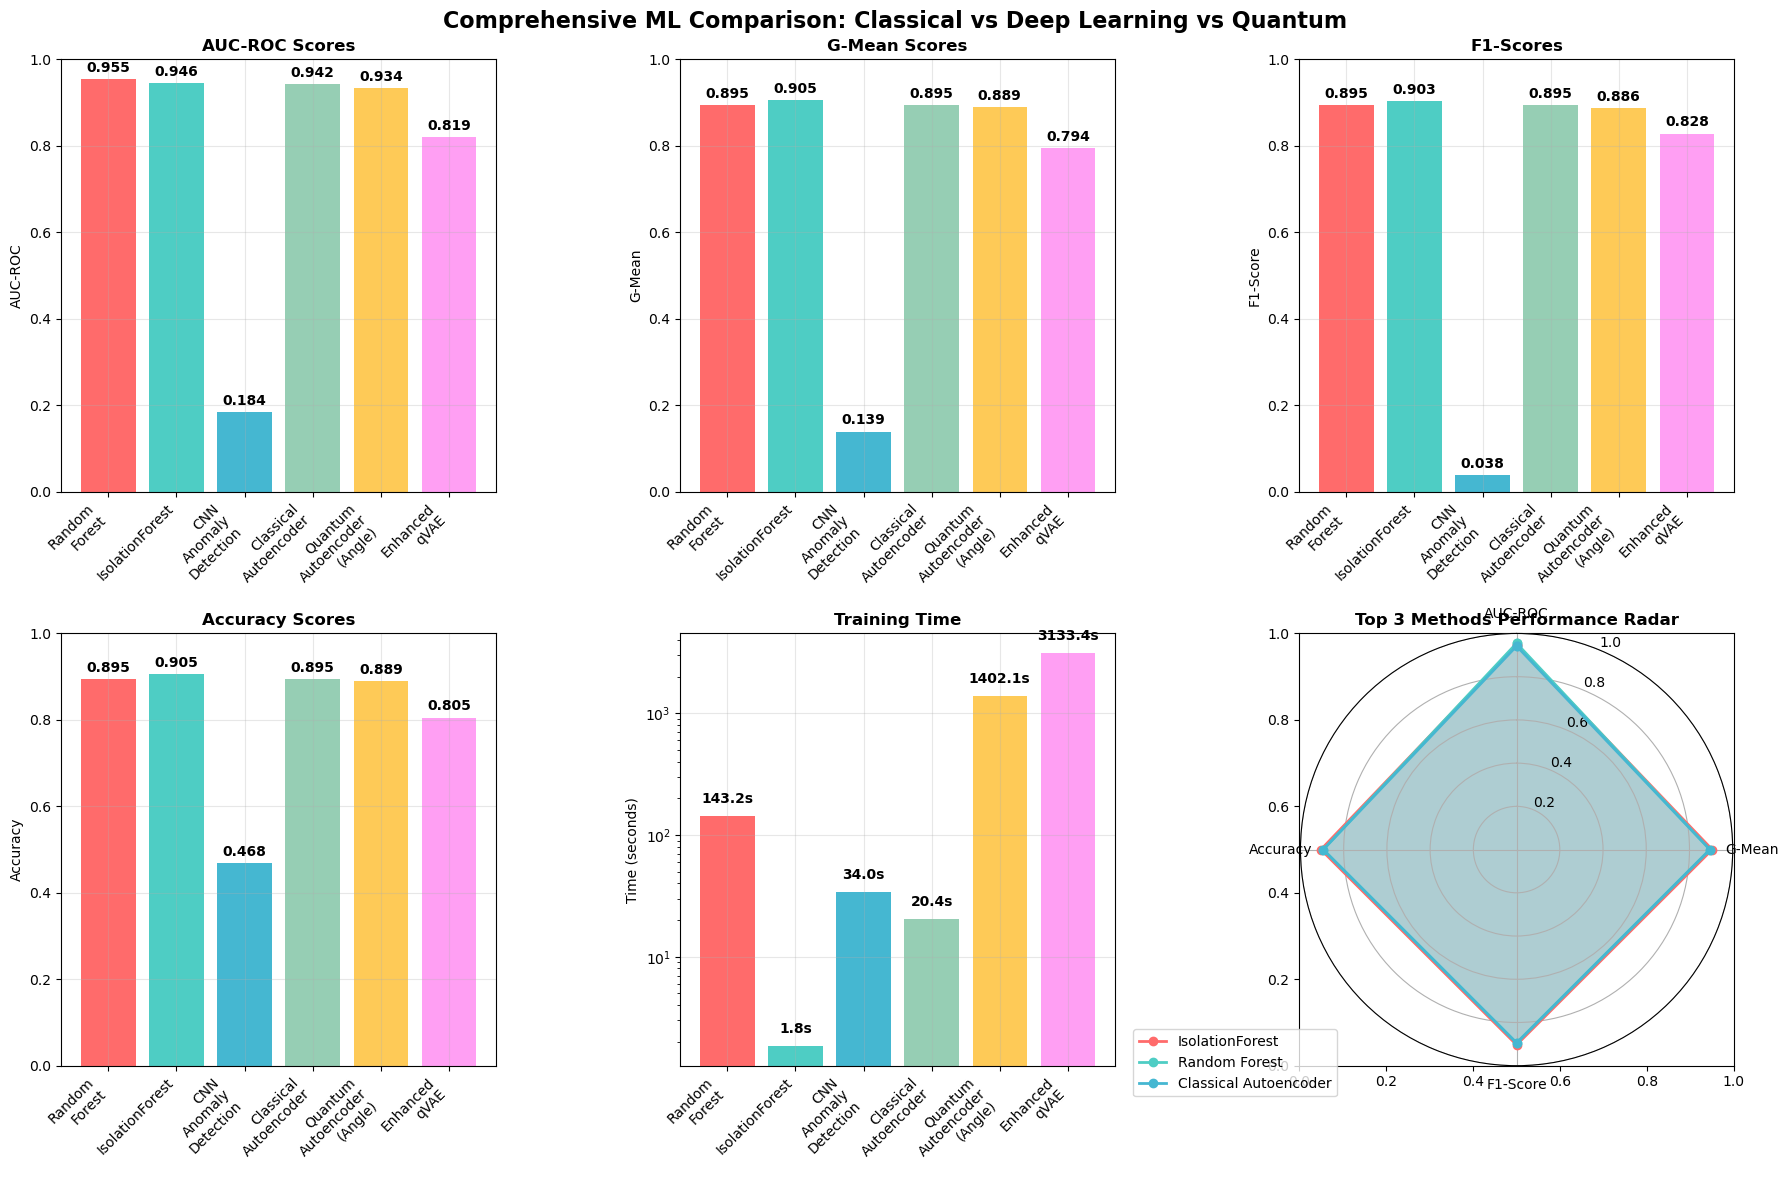


DETAILED RESULTS TABLE
Method                    AUC      G-Mean   F1       Acc      Time(s)    Type                
--------------------------------------------------------------------------------
Random Forest             0.9547   0.8947   0.8947   0.8947   143.2      classical_optimized 
IsolationForest           0.9456   0.9050   0.9032   0.9053   1.8        classical_optimized 
Classical Autoencoder     0.9418   0.8947   0.8947   0.8947   20.4       deep_learning_ae_optimized
Quantum Autoencoder (Angle) 0.9341   0.8891   0.8865   0.8895   1402.1     quantum_ml_basic_fixed
Enhanced qVAE             0.8194   0.7944   0.8279   0.8053   3133.4     quantum_ml_advanced_fixed
CNN Anomaly Detection     0.1845   0.1389   0.0381   0.4684   34.0       deep_learning_optimized

FINAL RECOMMENDATIONS
🏆 BEST OVERALL METHOD: IsolationForest
   Composite Score: 0.9249
   AUC-ROC: 0.9456
   G-Mean: 0.9050
   F1-Score: 0.9032
   Training Time: 1.8s

USE CASE RECOMMENDATIONS:
📊 Best for Balanced Per

In [12]:
# ==========================================
# Comprehensive Results Comparison and Visualization
# ==========================================

print("\n" + "="*80)
print("COMPREHENSIVE RESULTS COMPARISON")
print("="*80)

# 모든 결과 수집
all_results = {}

# 각 방법의 결과 수집 및 표준화
def collect_method_results(method_name, result_data):
    """
    각 방법의 결과를 표준화된 형태로 수집
    """
    if 'error' in result_data:
        return None
    
    try:
        eval_data = result_data.get('evaluation', {})
        
        if 'metrics' in eval_data:
            metrics = eval_data['metrics']
        else:
            metrics = eval_data
        
        # 표준화된 결과 형태
        return {
            'name': method_name,
            'type': result_data.get('type', 'unknown'),
            'auc': metrics.get('auc', 0),
            'accuracy': metrics.get('accuracy', 0),
            'precision': metrics.get('precision', 0),
            'recall': metrics.get('recall', 0),
            'f1_score': metrics.get('f1_score', 0),
            'gmean': metrics.get('gmean', 0),
            'training_time': result_data.get('training_time', 0),
            'best_params': result_data.get('best_params', {})
        }
    except Exception as e:
        print(f"Warning: Failed to collect results for {method_name}: {str(e)}")
        return None

# 결과 수집
methods = [
    ('Random Forest', rf_result),
    ('IsolationForest', if_result),
    ('CNN Anomaly Detection', cnn_result),
    ('Classical Autoencoder', ae_result),
    ('Quantum Autoencoder (Angle)', qae_result),
    ('Enhanced qVAE', qvae_result)
]

successful_methods = {}
for method_name, result_data in methods:
    collected_result = collect_method_results(method_name, result_data)
    if collected_result is not None:
        successful_methods[method_name] = collected_result
        print(f"✓ {method_name}: AUC={collected_result['auc']:.4f}, "
              f"G-Mean={collected_result['gmean']:.4f}, "
              f"F1={collected_result['f1_score']:.4f}, "
              f"Time={collected_result['training_time']:.1f}s")
    else:
        print(f"✗ {method_name}: Failed to run or collect results")

print(f"\nSuccessfully completed methods: {len(successful_methods)}/6")

if len(successful_methods) < 2:
    print("Insufficient successful methods for comprehensive comparison.")
else:
    # 성능 지표별 최고 성능 분석
    print("\n" + "="*60)
    print("PERFORMANCE ANALYSIS")
    print("="*60)
    
    # 각 지표별 최고 성능
    best_auc = max(successful_methods.values(), key=lambda x: x['auc'])
    best_gmean = max(successful_methods.values(), key=lambda x: x['gmean'])
    best_f1 = max(successful_methods.values(), key=lambda x: x['f1_score'])
    best_accuracy = max(successful_methods.values(), key=lambda x: x['accuracy'])
    fastest = min(successful_methods.values(), key=lambda x: x['training_time'])
    
    print(f"Best AUC-ROC: {best_auc['name']} ({best_auc['auc']:.4f})")
    print(f"Best G-Mean: {best_gmean['name']} ({best_gmean['gmean']:.4f})")
    print(f"Best F1-Score: {best_f1['name']} ({best_f1['f1_score']:.4f})")
    print(f"Best Accuracy: {best_accuracy['name']} ({best_accuracy['accuracy']:.4f})")
    print(f"Fastest Training: {fastest['name']} ({fastest['training_time']:.2f}s)")
    
    # 종합 성능 점수 계산 (AUC 50%, G-Mean 30%, F1 20%)
    for method in successful_methods.values():
        method['composite_score'] = (
            0.5 * method['auc'] + 
            0.3 * method['gmean'] + 
            0.2 * method['f1_score']
        )
    
    # 상위 3개 방법 선택
    top_3_methods = sorted(successful_methods.values(), 
                          key=lambda x: x['composite_score'], 
                          reverse=True)[:3]
    
    print(f"\nTOP 3 METHODS (Composite Score):")
    for i, method in enumerate(top_3_methods, 1):
        print(f"{i}. {method['name']}: {method['composite_score']:.4f}")
        print(f"   AUC={method['auc']:.4f}, G-Mean={method['gmean']:.4f}, "
              f"F1={method['f1_score']:.4f}, Time={method['training_time']:.1f}s")
    
    # 시각화
    print("\n" + "="*60)
    print("VISUALIZATION")
    print("="*60)
    
    # 그래프 생성
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Comprehensive ML Comparison: Classical vs Deep Learning vs Quantum', 
                 fontsize=16, fontweight='bold')
    
    # 방법별 데이터 준비
    method_names = list(successful_methods.keys())
    method_data = list(successful_methods.values())
    
    # 성능 지표 추출
    aucs = [m['auc'] for m in method_data]
    gmeans = [m['gmean'] for m in method_data]
    f1s = [m['f1_score'] for m in method_data]
    accuracies = [m['accuracy'] for m in method_data]
    times = [m['training_time'] for m in method_data]
    
    # 색상 설정
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3']
    
    # 1. AUC-ROC 비교
    bars1 = axes[0,0].bar(range(len(method_names)), aucs, color=colors[:len(method_names)])
    axes[0,0].set_title('AUC-ROC Scores', fontweight='bold')
    axes[0,0].set_ylabel('AUC-ROC')
    axes[0,0].set_xticks(range(len(method_names)))
    axes[0,0].set_xticklabels([name.replace(' ', '\n') for name in method_names], rotation=45, ha='right')
    axes[0,0].set_ylim(0, 1)
    axes[0,0].grid(True, alpha=0.3)
    for i, v in enumerate(aucs):
        axes[0,0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. G-Mean 비교
    bars2 = axes[0,1].bar(range(len(method_names)), gmeans, color=colors[:len(method_names)])
    axes[0,1].set_title('G-Mean Scores', fontweight='bold')
    axes[0,1].set_ylabel('G-Mean')
    axes[0,1].set_xticks(range(len(method_names)))
    axes[0,1].set_xticklabels([name.replace(' ', '\n') for name in method_names], rotation=45, ha='right')
    axes[0,1].set_ylim(0, 1)
    axes[0,1].grid(True, alpha=0.3)
    for i, v in enumerate(gmeans):
        axes[0,1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. F1-Score 비교
    bars3 = axes[0,2].bar(range(len(method_names)), f1s, color=colors[:len(method_names)])
    axes[0,2].set_title('F1-Scores', fontweight='bold')
    axes[0,2].set_ylabel('F1-Score')
    axes[0,2].set_xticks(range(len(method_names)))
    axes[0,2].set_xticklabels([name.replace(' ', '\n') for name in method_names], rotation=45, ha='right')
    axes[0,2].set_ylim(0, 1)
    axes[0,2].grid(True, alpha=0.3)
    for i, v in enumerate(f1s):
        axes[0,2].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 4. 정확도 비교
    bars4 = axes[1,0].bar(range(len(method_names)), accuracies, color=colors[:len(method_names)])
    axes[1,0].set_title('Accuracy Scores', fontweight='bold')
    axes[1,0].set_ylabel('Accuracy')
    axes[1,0].set_xticks(range(len(method_names)))
    axes[1,0].set_xticklabels([name.replace(' ', '\n') for name in method_names], rotation=45, ha='right')
    axes[1,0].set_ylim(0, 1)
    axes[1,0].grid(True, alpha=0.3)
    for i, v in enumerate(accuracies):
        axes[1,0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 5. 학습 시간 비교 (로그 스케일)
    bars5 = axes[1,1].bar(range(len(method_names)), times, color=colors[:len(method_names)])
    axes[1,1].set_title('Training Time', fontweight='bold')
    axes[1,1].set_ylabel('Time (seconds)')
    axes[1,1].set_xticks(range(len(method_names)))
    axes[1,1].set_xticklabels([name.replace(' ', '\n') for name in method_names], rotation=45, ha='right')
    axes[1,1].set_yscale('log')
    axes[1,1].grid(True, alpha=0.3)
    for i, v in enumerate(times):
        axes[1,1].text(i, v * 1.2, f'{v:.1f}s', ha='center', va='bottom', fontweight='bold')
    
    # 6. 레이더 차트 (상위 3개 방법)
    if len(top_3_methods) >= 3:
        categories = ['AUC-ROC', 'G-Mean', 'F1-Score', 'Accuracy']
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        angles += angles[:1]  # 첫 번째 각도를 마지막에 추가하여 닫힌 도형 만들기
        
        # Replace axes[1,2] with polar projection for radar chart
        plt.subplot(2, 3, 6, projection='polar')
        ax_radar = plt.gca()
        ax_radar.set_theta_offset(np.pi / 2)
        ax_radar.set_theta_direction(-1)
        
        for i, method in enumerate(top_3_methods):
            values = [method['auc'], method['gmean'], method['f1_score'], method['accuracy']]
            values += values[:1]  # 첫 번째 값을 마지막에 추가
            
            ax_radar.plot(angles, values, 'o-', linewidth=2, 
                         label=method['name'].replace('Optimized ', ''), color=colors[i])
            ax_radar.fill(angles, values, alpha=0.25, color=colors[i])
        
        ax_radar.set_xticks(angles[:-1])
        ax_radar.set_xticklabels(categories)
        ax_radar.set_ylim(0, 1)
        ax_radar.set_title('Top 3 Methods Performance Radar', fontsize=12, fontweight='bold')
        ax_radar.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    else:
        axes[1,2].text(0.5, 0.5, 'Insufficient methods\nfor radar chart', 
                       ha='center', va='center', transform=axes[1,2].transAxes, fontsize=12)
        axes[1,2].set_title('Radar Chart', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 요약 테이블 출력
    print("\n" + "="*80)
    print("DETAILED RESULTS TABLE")
    print("="*80)
    print(f"{'Method':<25} {'AUC':<8} {'G-Mean':<8} {'F1':<8} {'Acc':<8} {'Time(s)':<10} {'Type':<20}")
    print("-" * 80)
    
    for method in sorted(successful_methods.values(), key=lambda x: x['auc'], reverse=True):
        print(f"{method['name']:<25} {method['auc']:<8.4f} {method['gmean']:<8.4f} "
              f"{method['f1_score']:<8.4f} {method['accuracy']:<8.4f} {method['training_time']:<10.1f} "
              f"{method['type']:<20}")
    
    print("\n" + "="*80)
    print("FINAL RECOMMENDATIONS")
    print("="*80)
    
    if len(successful_methods) >= 1:
        best_overall = max(successful_methods.values(), key=lambda x: x['composite_score'])
        print(f"🏆 BEST OVERALL METHOD: {best_overall['name']}")
        print(f"   Composite Score: {best_overall['composite_score']:.4f}")
        print(f"   AUC-ROC: {best_overall['auc']:.4f}")
        print(f"   G-Mean: {best_overall['gmean']:.4f}")
        print(f"   F1-Score: {best_overall['f1_score']:.4f}")
        print(f"   Training Time: {best_overall['training_time']:.1f}s")
        
        # 사용 사례별 추천
        print(f"\nUSE CASE RECOMMENDATIONS:")
        print(f"📊 Best for Balanced Performance: {best_overall['name']}")
        print(f"⚡ Fastest Training: {fastest['name']} ({fastest['training_time']:.1f}s)")
        print(f"🎯 Highest Precision Detection: {best_auc['name']} (AUC: {best_auc['auc']:.4f})")
        
        # 방법론별 특성 설명
        print(f"\nMETHOD CHARACTERISTICS:")
        for method_name, result in successful_methods.items():
            method_type = result['type']
            if 'classical' in method_type:
                category = "📈 Classical ML"
            elif 'deep_learning' in method_type:
                category = "🧠 Deep Learning"
            elif 'quantum' in method_type:
                category = "⚛️  Quantum ML"
            else:
                category = "🔧 Other"
            
            print(f"  {category}: {method_name} - AUC: {result['auc']:.3f}, Time: {result['training_time']:.1f}s")
    
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE")
    print("="*80)